# Non-resonant 2-photon ionization of Ar using 9.3eV light

We perform non-resonant 2-photon ionization of argon atoms using 9.3eV femtosecond pulses produced via high harmonic generation. 

## Experimental conditions:
NIR pulse energy into compressor - 11.5 mJ <br>
Approximate blue energy - 2.4 mJ <br>
HHG medium - Kr <br>
HHG medium pressure - 3.25 Torr <br>
Filter - 0.250mm MgF2  <br>
Back-focusing mirror - Protected aluminium <br>
Jet species - Ar <br>
Jet backing pressure - 75 PSI <br>

In [1]:
######################################
### loading in necessary libraries ###
######################################

import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import ticker
from matplotlib.colors import PowerNorm, LogNorm
from scipy.stats import norm
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
################################
### to make plots look nicer ###
################################

#sns.set_context("poster")
#sns.set(style = "ticks")

# Here we first load in the TOF and (x,y) hit positions of electrons and ions

### When we load in the data, we use some list comprehension and 'if' statements to set conditions on the ion TOF and electron TOF to only ions of interest and associated electrons. In the data, columns (0,1,2) are the first electron hit (TOF,x,y). Columns (3,4,5) are the second electron hit. Columns (6,7,8) are the ion hit (TOF,x,y). We are taking 2 electron hits since conditions in 333 were challenging and count rates low.

In [3]:
path_to_data = '/Users/work/Desktop/Ar_3rd3rd_SI_raw_06_05_19.txt'

Ar_raw_hit0 = np.loadtxt(fname = path_to_data, usecols=(0,1,2,6,7,8))
Ar_raw_hit0 = [[float(e_TOF),float(e_x),float(e_y),
               float(i_TOF),float(i_x),float(i_y)] for e_TOF,e_x,e_y,i_TOF,i_x,i_y in Ar_raw_hit0 if i_TOF > 10440 and i_TOF < 10480 and e_TOF > 50.0 and e_TOF < 60.0]
Ar_raw_hit0 = list(zip(*Ar_raw_hit0))

Ar_raw_hit1 = np.loadtxt(fname = path_to_data, usecols=(3,4,5,6,7,8))
Ar_raw_hit1 = [[float(e_TOF),float(e_x),float(e_y),
               float(i_TOF),float(i_x),float(i_y)] for e_TOF,e_x,e_y,i_TOF,i_x,i_y in Ar_raw_hit1 if i_TOF > 10440 and i_TOF < 10480 and e_TOF > 50.0 and e_TOF < 60.0]
Ar_raw_hit1 = list(zip(*Ar_raw_hit1))

In [4]:
###########################################
### how many events we are working with ###
###########################################

print(len(Ar_raw_hit0[0]))
print(len(Ar_raw_hit1[0]))

15011
11369


In [5]:
#############
### HIT 1 ###
#############

e_TOF_0 = np.array(Ar_raw_hit0[0])
e_x_0 = np.array(Ar_raw_hit0[1])
e_y_0 = np.array(Ar_raw_hit0[2])
i_TOF_0 = np.array(Ar_raw_hit0[3])
i_x_0 = np.array(Ar_raw_hit0[4])
i_y_0 = np.array(Ar_raw_hit0[5])

###################################################################################
### applying rotation matrix by pi/2 to ion (x,y) hits to get detector oriented ###
###################################################################################
i_x0 = i_x_0*np.cos(np.pi/2) - i_y_0*np.sin(np.pi/2)
i_y0 = i_x_0*np.sin(np.pi/2) + i_y_0*np.cos(np.pi/2)

########################################################################################
### applying rotation matrix by pi/3 to electron (x,y) hits to get detector oriented ###
########################################################################################
elec_det_theta = np.pi/3
e_x0 = e_x_0*np.cos(elec_det_theta) - e_y_0*np.sin(elec_det_theta)
e_y0 = e_x_0*np.sin(elec_det_theta) + e_y_0*np.cos(elec_det_theta)

In [6]:
#############
### HIT 2 ###
#############

e_TOF_1 = np.array(Ar_raw_hit1[0])
e_x_1 = np.array(Ar_raw_hit1[1])
e_y_1 = np.array(Ar_raw_hit1[2])
i_TOF_1 = np.array(Ar_raw_hit1[3])
i_x_1 = np.array(Ar_raw_hit1[4])
i_y_1 = np.array(Ar_raw_hit1[5])

###################################################################################
### applying rotation matrix by pi/2 to ion (x,y) hits to get detector oriented ###
###################################################################################
i_x1 = i_x_1*np.cos(np.pi/2) - i_y_1*np.sin(np.pi/2)
i_y1 = i_x_1*np.sin(np.pi/2) + i_y_1*np.cos(np.pi/2)

########################################################################################
### applying rotation matrix by pi/3 to electron (x,y) hits to get detector oriented ###
########################################################################################
elec_det_theta = np.pi/3
e_x1 = e_x_1*np.cos(elec_det_theta) - e_y_1*np.sin(elec_det_theta)
e_y1 = e_x_1*np.sin(elec_det_theta) + e_y_1*np.cos(elec_det_theta)

In [7]:
##########################################################
### apply TOF shift to electrons and ions if necessary ###
##########################################################

TOF_shift = -0.0

e_TOF0 = e_TOF_0 + TOF_shift
i_TOF0 = i_TOF_0 + TOF_shift

e_TOF1 = e_TOF_1 + TOF_shift
i_TOF1 = i_TOF_1 + TOF_shift

53.799992
55.601


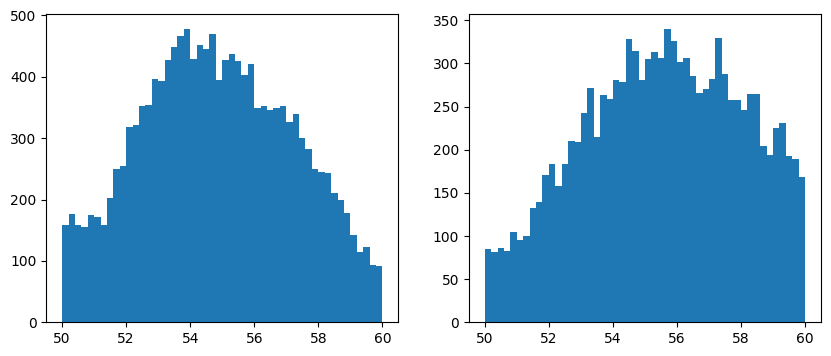

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#########################
### peak of TOF hit 1 ###
#########################

a = ax1.hist(e_TOF0,bins=50)
b = list(zip(*a[0:2]))
e_TOF_max0 = max(b)[1]
print(e_TOF_max0)

#########################
### peak of TOF hit 2 ###
#########################

a = ax2.hist(e_TOF1,bins=50)
b = list(zip(*a[0:2]))
e_TOF_max1 = max(b)[1]
print(e_TOF_max1)

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1028811597.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


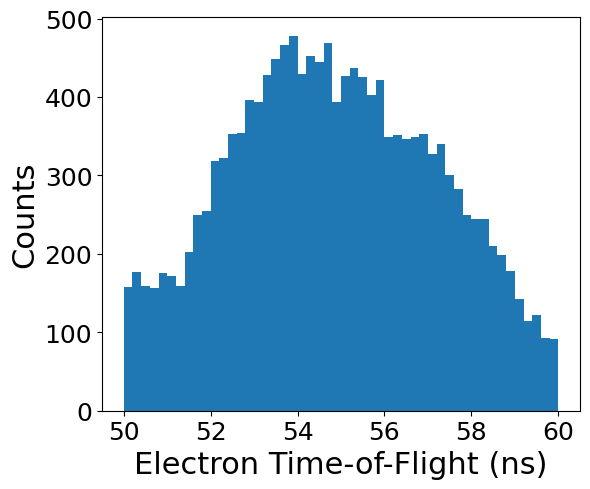

In [9]:
#######################################
### make histogram of electron TOFs ###
#######################################

fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.hist(e_TOF0,bins=50,histtype='stepfilled')
ax.set_xlabel('Electron Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)

fig.tight_layout()
fig.show()

In [10]:
#########################################
### fit TOFs with normal distribution ###
#########################################

(mu_eTOF0, sigma_eTOF0) = norm.fit(e_TOF0)
e_TOF_fit0 = mu_eTOF0
print(e_TOF_fit0)

(mu_eTOF1, sigma_eTOF1) = norm.fit(e_TOF1)
e_TOF_fit1 = mu_eTOF1
print(e_TOF_fit1)

54.842498907467856
55.52046925850999


10457.568
10456.816


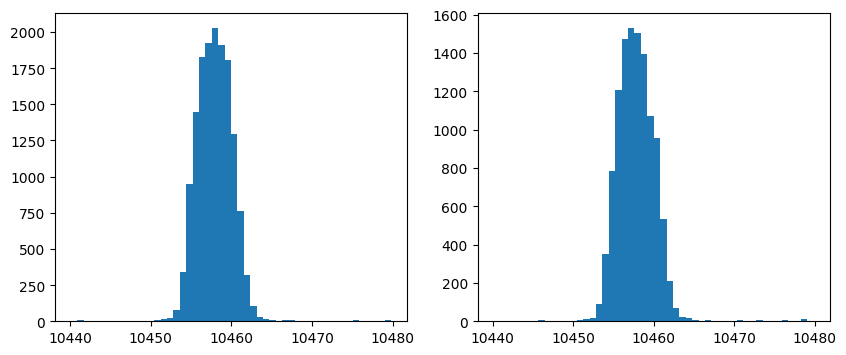

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

########################
### peak of ion1 TOF ###
########################

a = ax1.hist(i_TOF0,bins=50)
b = list(zip(*a[0:2]))
i_TOF_max0 = max(b)[1]
print(i_TOF_max0)

########################
### peak of ion2 TOF ###
########################

a = ax2.hist(i_TOF1,bins=50)
b = list(zip(*a[0:2]))
i_TOF_max1 = max(b)[1]
print(i_TOF_max1)

39.69999999999891


/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1083044796.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


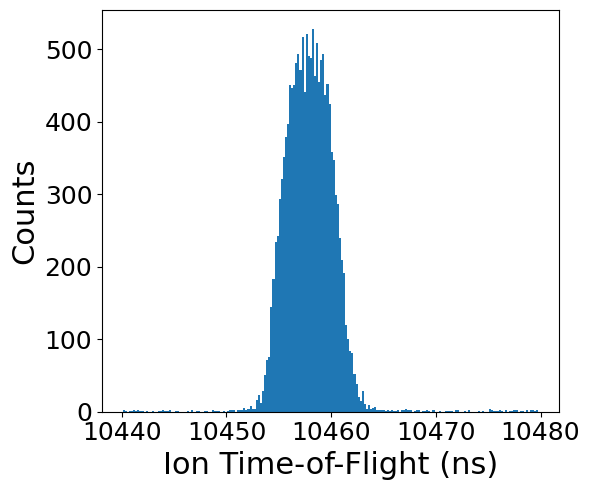

In [12]:
##################################
### make histogram of ion TOFs ###
##################################

fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.hist(i_TOF0,bins=200,histtype='stepfilled')
ax.set_xlabel('Ion Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)
fig.tight_layout()
fig.show()

print(np.amax(i_TOF0)-np.amin(i_TOF0)) #difference in max and min TOF

In [13]:
#############################################
### fit ion TOFs with normal distribution ###
#############################################

(mu_iTOF0, sigma_iTOF0) = norm.fit(i_TOF0)
i_TOF_fit0 = mu_iTOF0
print(i_TOF_fit0)

(mu_iTOF1, sigma_iTOF1) = norm.fit(i_TOF1)
i_TOF_fit1 = mu_iTOF1
print(i_TOF_fit1)

10457.921224435415
10457.830143372328


-3.5980294552471475
4.289068631448855


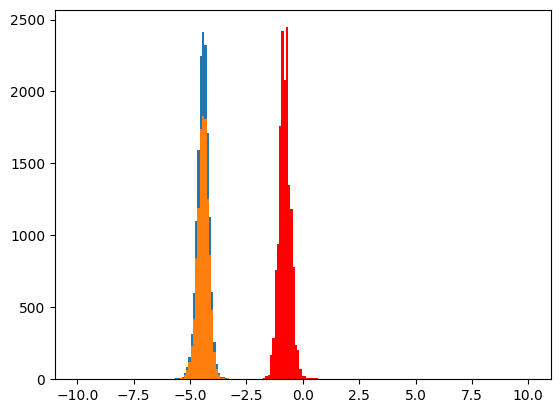

In [14]:
####################################
### histogram of ion x positions ###
####################################
ix_hist0 = plt.hist(i_x0,bins=np.linspace(-10,10,200),color='r')
ix_pairs0 = list(zip(*ix_hist0[0:2]))
i_x_offset0 = max(ix_pairs0)[1]

####################################
### histogram of ion y positions ###
####################################
iy_hist0 = plt.hist(i_y0,bins=np.linspace(-10,10,200))
iy_pairs0 = list(zip(*iy_hist0[0:2]))
i_y_offset0 = max(iy_pairs0)[1]

#####################################
### fitting electron1 x positions ###
#####################################
(mu_ex0, sigma_ex0) = norm.fit(e_x0)
e_x_offset0 = mu_ex0

#####################################
### fitting electron1 y positions ###
#####################################
(mu_ey0, sigma_ey0) = norm.fit(e_y0)
e_y_offset0 = mu_ey0

####################################
### histogram of ion x positions ###
####################################
ix_hist1 = plt.hist(i_x1,bins=np.linspace(-10,10,200),color='r')
ix_pairs1 = list(zip(*ix_hist1[0:2]))
i_x_offset1 = max(ix_pairs1)[1]

####################################
### histogram of ion y positions ###
####################################
iy_hist1 = plt.hist(i_y1,bins=np.linspace(-10,10,200))
iy_pairs1 = list(zip(*iy_hist1[0:2]))
i_y_offset1 = max(iy_pairs1)[1]

#####################################
### fitting electron2 x positions ###
#####################################
(mu_ex1, sigma_ex1) = norm.fit(e_x1)
e_x_offset1 = mu_ex1

#####################################
### fitting electron2 y positions ###
#####################################
(mu_ey1, sigma_ey1) = norm.fit(e_y1)
e_y_offset1 = mu_ey1

print(mu_ex0)
print(mu_ey0)

In [15]:
############################################################
### offset ion (x,y) hit positions to center on detector ###
############################################################
i_x0 = i_x0 - i_x_offset0
i_y0 = i_y0 - i_y_offset0

i_x1 = i_x1 - i_x_offset1
i_y1 = i_y1 - i_y_offset1

###################################################################
#### offset electron (x,y) hit positions to center on detector ####
## not always necessary and can be checked to see if beneficial ###
###################################################################
#e_x = e_x - mu_ex
#e_y = e_y - mu_ey

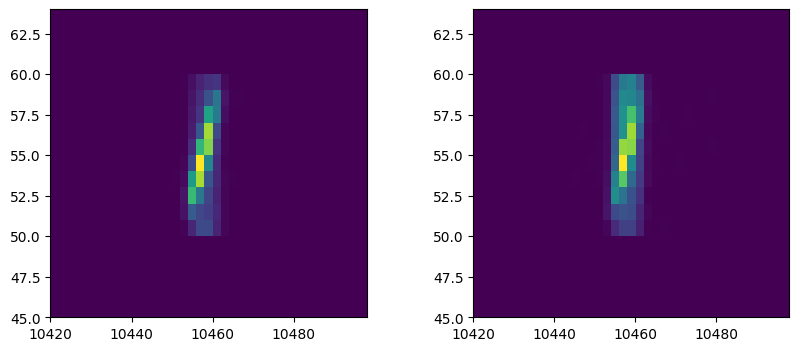

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#################################
### ion vs electron TOF hit 1 ###
#################################
x_edges = np.arange(10420,10500,2)
y_edges = np.arange(45,65,1)
H0, x_edges, y_edges = np.histogram2d(i_TOF0,e_TOF0,bins=(x_edges,y_edges))
H0 = H0.T

ax1.imshow(H0, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],aspect=80/20,cmap='viridis')

#################################
### ion vs electron TOF hit 2 ###
#################################
x_edges = np.arange(10420,10500,2)
y_edges = np.arange(45,65,1)
H1, x_edges, y_edges = np.histogram2d(i_TOF1,e_TOF1,bins=(x_edges,y_edges))
H1 = H1.T

ax2.imshow(H1, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],aspect=80/20,cmap='viridis')

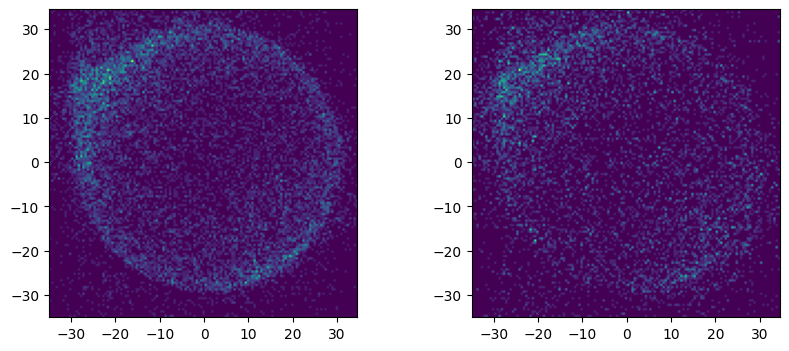

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

################################
##### electron (x,y) hit 1 #####
################################
pos_ex_edges = np.arange(-35,35,0.5)
pos_ey_edges = np.arange(-35,35,0.5)
H_e_pos0, ex_edges, ey_edges = np.histogram2d(e_x0,e_y0,bins=(pos_ex_edges,pos_ey_edges))
H_e_pos0 = H_e_pos0.T

ax1.imshow(H_e_pos0, origin='lower', extent=[pos_ex_edges[0], pos_ex_edges[-1], pos_ey_edges[0], pos_ey_edges[-1]],cmap = 'viridis')

################################
##### electron (x,y) hit 2 #####
################################
pos_ex_edges = np.arange(-35,35,0.5)
pos_ey_edges = np.arange(-35,35,0.5)
H_e_pos1, ex_edges, ey_edges = np.histogram2d(e_x1,e_y1,bins=(pos_ex_edges,pos_ey_edges))
H_e_pos1 = H_e_pos1.T

ax2.imshow(H_e_pos1, origin='lower', extent=[pos_ex_edges[0], pos_ex_edges[-1], pos_ey_edges[0], pos_ey_edges[-1]],cmap = 'viridis')

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/566546036.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/566546036.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


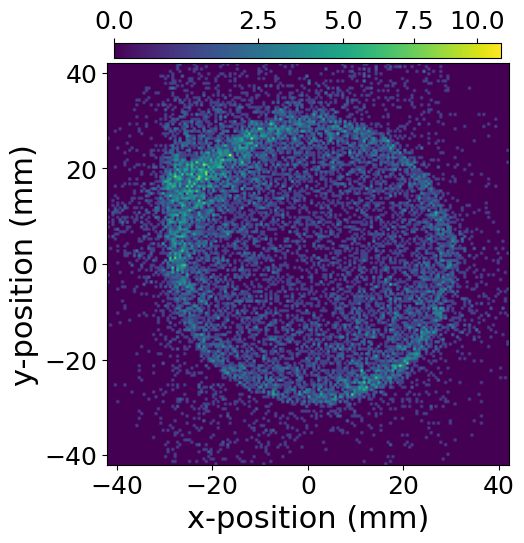

In [18]:
################################
##### electron (x,y) hit 1 #####
################################
fig, ax = plt.subplots(1,1,figsize=(6,5))

pos_ex_edges = np.arange(-42,42.5,0.5)
pos_ey_edges = np.arange(-42,42.5,0.5)
H_e_pos, ex_edges, ey_edges = np.histogram2d(e_x0,e_y0,bins=(pos_ex_edges,pos_ey_edges))
H_e_pos = H_e_pos.T

im = ax.imshow(H_e_pos, origin='lower', extent=[pos_ex_edges[0], pos_ex_edges[-1], pos_ey_edges[0], pos_ey_edges[-1]],cmap = 'viridis',norm=PowerNorm(gamma=2/3))

ax.set_xlabel('x-position (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('y-position (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)

ax.set_yticks([-40,-20,0,20,40])

cb_ax = fig.add_axes([0.225, 0.98, 0.645, 0.03])
cb = fig.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig.tight_layout()
fig.show()

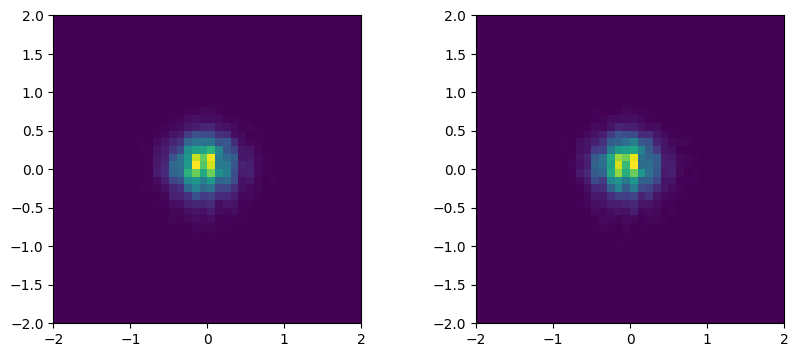

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###########################
##### ion (x,y) hit 1 #####
###########################
pos_ix_edges = np.arange(-2,2.1,0.1)
pos_iy_edges = np.arange(-2,2.1,0.1)
H_i_pos0, ix_edges, iy_edges = np.histogram2d(i_x0,i_y0,bins=(pos_ix_edges,pos_iy_edges))
H_i_pos0 = H_i_pos0.T

ax1.imshow(H_i_pos0, origin='lower', extent=[pos_ix_edges[0], pos_ix_edges[-1], pos_iy_edges[0], pos_iy_edges[-1]],cmap='viridis')

###########################
##### ion (x,y) hit 2 #####
###########################
pos_ix_edges = np.arange(-2,2.1,0.1)
pos_iy_edges = np.arange(-2,2.1,0.1)
H_i_pos1, ix_edges, iy_edges = np.histogram2d(i_x1,i_y1,bins=(pos_ix_edges,pos_iy_edges))
H_i_pos1 = H_i_pos1.T

ax2.imshow(H_i_pos1, origin='lower', extent=[pos_ix_edges[0], pos_ix_edges[-1], pos_iy_edges[0], pos_iy_edges[-1]],cmap='viridis')

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/786203513.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


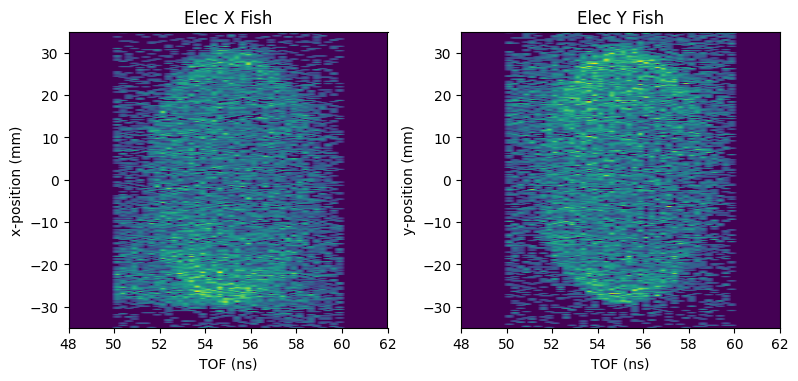

In [20]:
#############################
########### hit 1 ###########
###### 'electron fish' ######
#### (TOF,x) and (TOF,y) ####
#############################
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,6))

eTOF_edges = np.arange(48,62.25,0.25)
ex_edges = np.arange(-35,35.25,0.25)
ey_edges = np.arange(-35,35.25,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF0,e_x0,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF0,e_y0,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

ax1.imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_title('Elec X Fish')
ax1.set_xlabel('TOF (ns)')
ax1.set_ylabel('x-position (mm)')
ax2.imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_title('Elec Y Fish')
ax2.set_xlabel('TOF (ns)')
ax2.set_ylabel('y-position (mm)')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3511847180.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3511847180.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


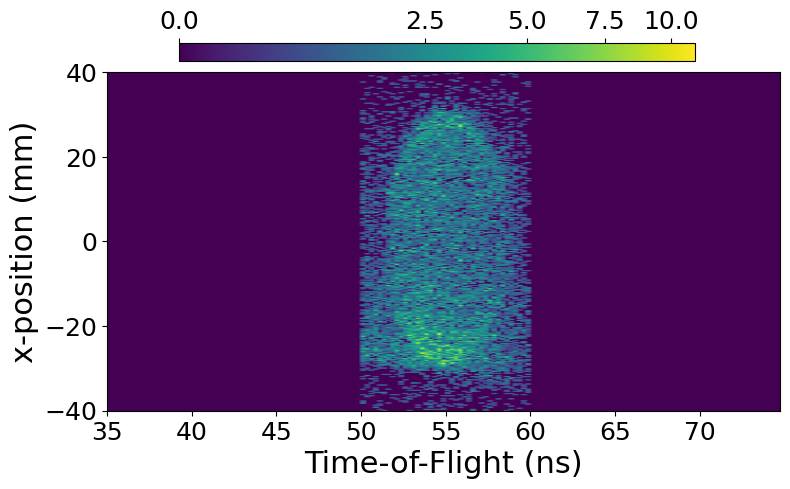

In [21]:
#############################
########### hit 1 ###########
###### 'electron fish' ######
########## (TOF,x) ##########
#############################
fig, ax1 = plt.subplots(1,1,figsize=(8,6))

eTOF_edges = np.arange(35,75,0.25)
ex_edges = np.arange(-40,40.2,0.25)
ey_edges = np.arange(-40,40.2,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF0,e_x0,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

im = ax1.imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=10/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_xlabel('Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('x-position (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=18)

cb_ax = fig.add_axes([0.23, 0.8, 0.645, 0.03])
cb = fig.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1451310441.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1451310441.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


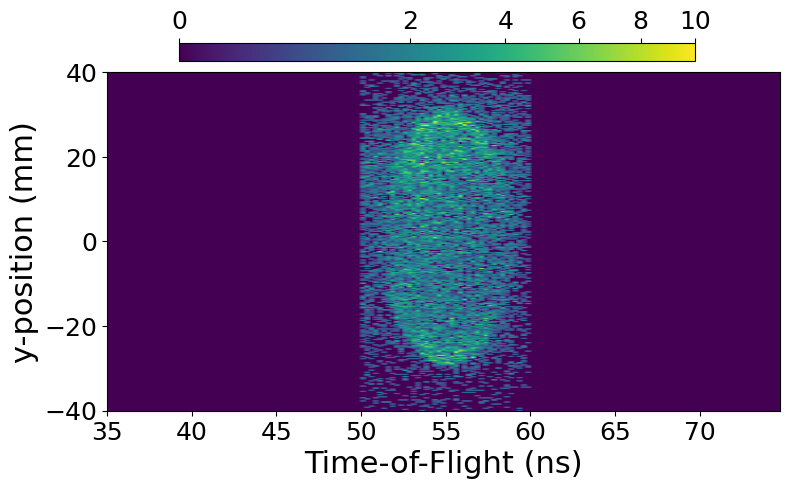

In [22]:
#############################
########### hit 1 ###########
###### 'electron fish' ######
########## (TOF,y) ##########
#############################
fig, ax2 = plt.subplots(1,1,figsize=(8,6))

eTOF_edges = np.arange(35,75,0.25)
ex_edges = np.arange(-40,40.2,0.25)
ey_edges = np.arange(-40,40.2,0.25)


H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF0,e_y0,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

im = ax2.imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=10/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_xlabel('Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.set_ylabel('y-position (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.tick_params(labelsize=18)

cb_ax = fig.add_axes([0.23, 0.8, 0.645, 0.03])
cb = fig.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2268956530.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


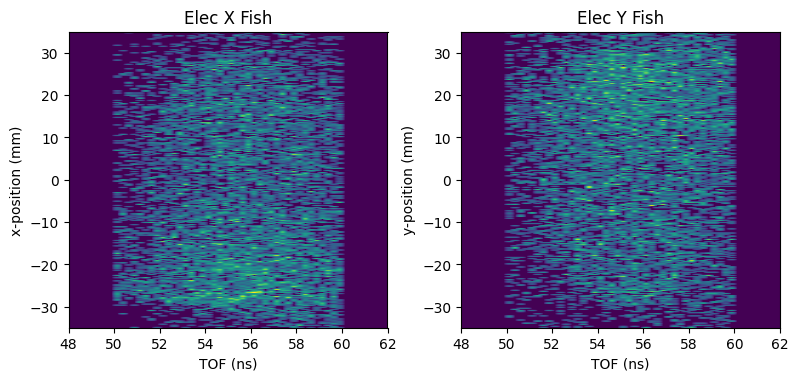

In [23]:
#############################
########### hit 2 ###########
###### 'electron fish' ######
#### (TOF,x) and (TOF,y) ####
#############################
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,6))

eTOF_edges = np.arange(48,62.25,0.25)
ex_edges = np.arange(-35,35.25,0.25)
ey_edges = np.arange(-35,35.25,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF1,e_x1,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF1,e_y1,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

ax1.imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_title('Elec X Fish')
ax1.set_xlabel('TOF (ns)')
ax1.set_ylabel('x-position (mm)')
ax2.imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_title('Elec Y Fish')
ax2.set_xlabel('TOF (ns)')
ax2.set_ylabel('y-position (mm)')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2345197960.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


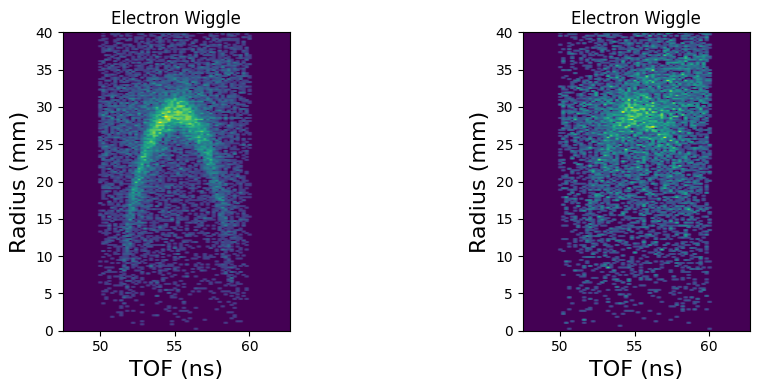

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###############################
############ hit 1 ############
###### 'electron wiggle' ######
########### (TOF,r) ###########
###############################

### compute radius for (x,y) hit position ###
e_rad0 = np.sqrt(e_x0**2 + e_y0**2)

eTOF_edges = np.arange(47.5,62.7,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle0, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF0,e_rad0,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle0 = H_e0_wiggle0.T

ax1.imshow(H_e0_wiggle0, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_title('Electron Wiggle')
ax1.set_xlabel('TOF (ns)', fontsize=16)
ax1.set_ylabel('Radius (mm)', fontsize=16)

###############################
############ hit 2 ############
###### 'electron wiggle' ######
########### (TOF,r) ###########
###############################

### compute radius for (x,y) hit position ###
e_rad1 = np.sqrt(e_x1**2 + e_y1**2)

eTOF_edges = np.arange(47.5,62.7,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle1, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF1,e_rad1,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle1 = H_e0_wiggle1.T

ax2.imshow(H_e0_wiggle1, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_title('Electron Wiggle')
ax2.set_xlabel('TOF (ns)', fontsize=16)
ax2.set_ylabel('Radius (mm)', fontsize=16)

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/93095899.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/93095899.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


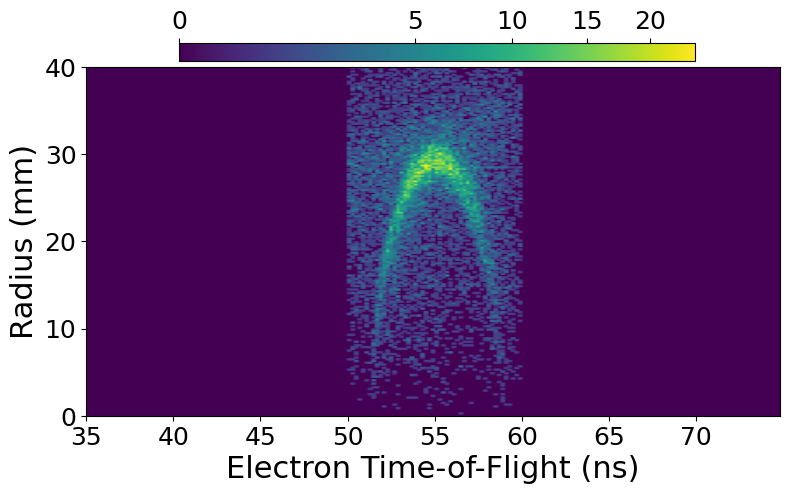

In [25]:
###############################
############ hit 1 ############
###### 'electron wiggle' ######
########### (TOF,r) ###########
###############################

### compute radius for (x,y) hit position ###

e_rad0 = np.sqrt(e_x0**2 + e_y0**2)

fig, ax = plt.subplots(1,1,figsize=(8,6))

eTOF_edges = np.arange(35,75,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF0,e_rad0,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle = H_e0_wiggle.T

im = ax.imshow(H_e0_wiggle, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax.set_xlabel('Electron Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Radius (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)

cb_ax = fig.add_axes([0.23, 0.8, 0.645, 0.03])
cb = fig.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig.tight_layout()
fig.show()

In [26]:
##############################################################
##### correct electron hit 1 E x B drift in spectrometer #####
########## apply same correction to electron hit 2 ###########
##############################################################
wiggles_tof_ex = [93.5, 189.0, 1.0, 1.0]
wiggles_tof_ey = [93.5, 189.0, 0.0, -1.0]

ex_corr = np.polyfit(wiggles_tof_ex[0:2], wiggles_tof_ex[2:], 1)
px = np.poly1d(ex_corr)
ey_corr = np.polyfit(wiggles_tof_ey[0:2], wiggles_tof_ey[2:], 1)
py = np.poly1d(ey_corr)

e_x0 = e_x0 - px(e_TOF0)
e_y0 = e_y0 - py(e_TOF0)

e_x1 = e_x1 - px(e_TOF1)
e_y1 = e_y1 - py(e_TOF1)

# Fish and wiggle spectra after correcting ExB drift

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/565670989.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


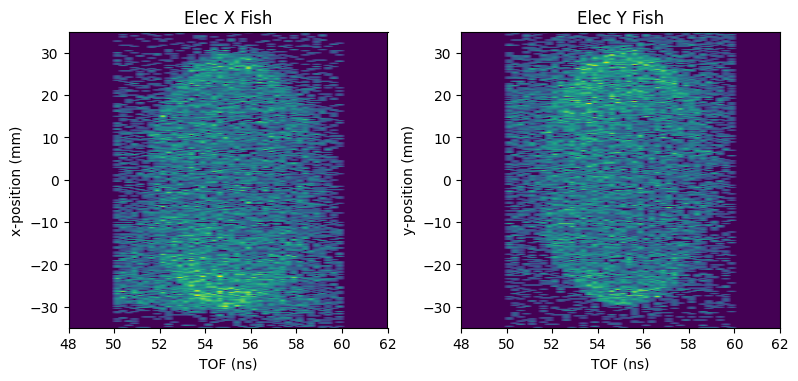

In [27]:
###############################
############ hit 1 ############
### corrected electron fish ###
###############################
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,6))

eTOF_edges = np.arange(48,62.25,0.25)
ex_edges = np.arange(-35,35.25,0.25)
ey_edges = np.arange(-35,35.25,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF0,e_x0,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF0,e_y0,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

ax1.imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_title('Elec X Fish')
ax1.set_xlabel('TOF (ns)')
ax1.set_ylabel('x-position (mm)')
ax2.imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_title('Elec Y Fish')
ax2.set_xlabel('TOF (ns)')
ax2.set_ylabel('y-position (mm)')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3783931247.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


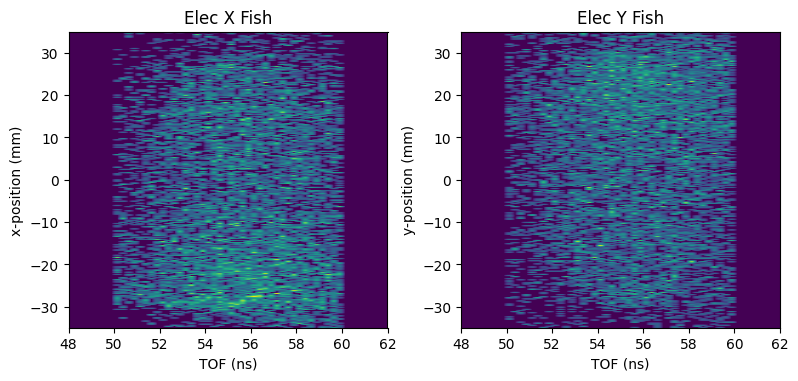

In [28]:
###############################
############ hit 2 ############
### corrected electron fish ###
###############################
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,6))

eTOF_edges = np.arange(48,62.25,0.25)
ex_edges = np.arange(-35,35.25,0.25)
ey_edges = np.arange(-35,35.25,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF1,e_x1,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF1,e_y1,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

ax1.imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_title('Elec X Fish')
ax1.set_xlabel('TOF (ns)')
ax1.set_ylabel('x-position (mm)')
ax2.imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=13/70,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_title('Elec Y Fish')
ax2.set_xlabel('TOF (ns)')
ax2.set_ylabel('y-position (mm)')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3415092861.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3415092861.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


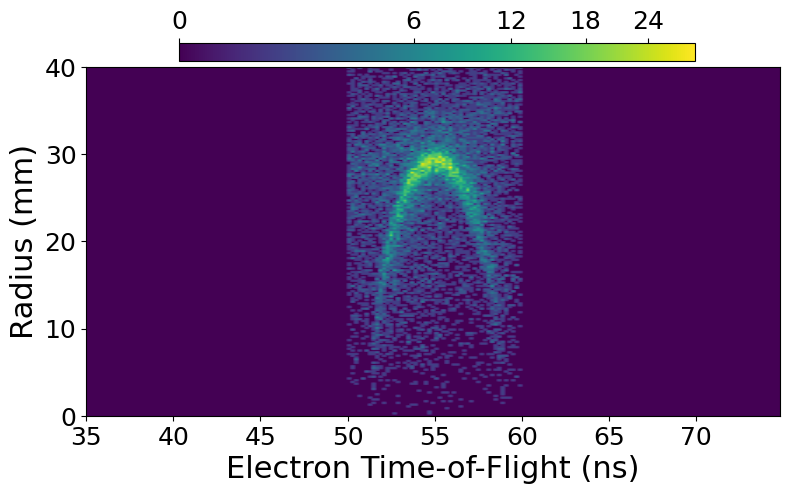

In [29]:
#################################
############# hit 1 #############
### corrected electron wiggle ###
#################################

e_rad0 = np.sqrt(e_x0**2 + e_y0**2)

fig, ax = plt.subplots(1,1,figsize=(8,6))

eTOF_edges = np.arange(35,75,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF0,e_rad0,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle = H_e0_wiggle.T

im = ax.imshow(H_e0_wiggle, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax.set_xlabel('Electron Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Radius (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)

cb_ax = fig.add_axes([0.23, 0.8, 0.645, 0.03])
cb = fig.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/4151975031.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/4151975031.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


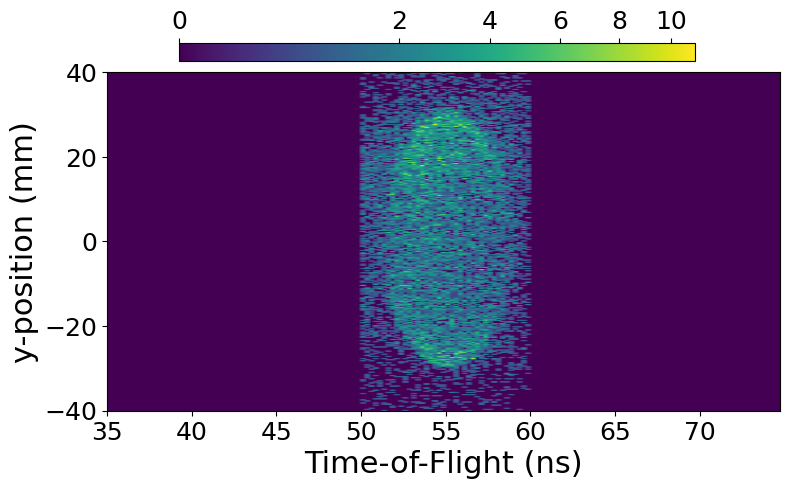

In [30]:
#################################
############# hit 1 #############
### corrected electron y fish ###
#################################
fig, ax2 = plt.subplots(1,1,figsize=(8,6))

eTOF_edges = np.arange(35,75,0.25)
ex_edges = np.arange(-40,40.2,0.25)
ey_edges = np.arange(-40,40.2,0.25)

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF0,e_y0,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

im = ax2.imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=10/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_xlabel('Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.set_ylabel('y-position (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.tick_params(labelsize=18)

cb_ax = fig.add_axes([0.23, 0.8, 0.645, 0.03])
cb = fig.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/789344595.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/789344595.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


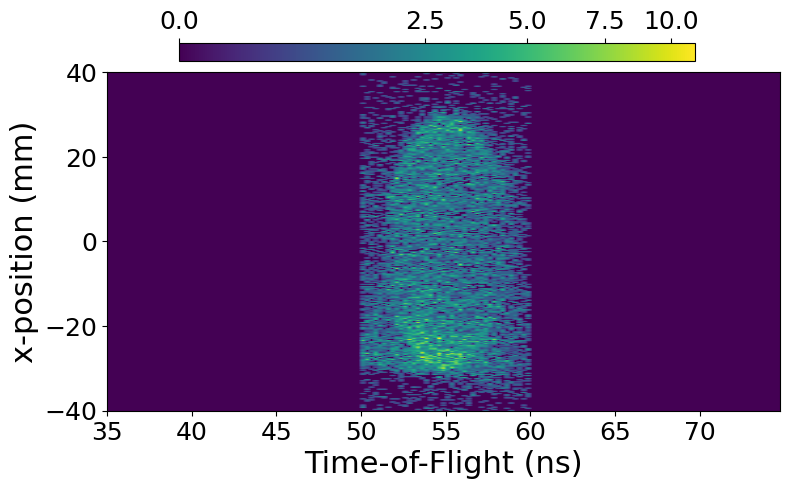

In [31]:
#################################
############# hit 1 #############
### corrected electron x fish ###
#################################
fig, ax1 = plt.subplots(1,1,figsize=(8,6))

eTOF_edges = np.arange(35,75,0.25)
ex_edges = np.arange(-40,40.2,0.25)
ey_edges = np.arange(-40,40.2,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF0,e_x0,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

im = ax1.imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=10/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_xlabel('Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('x-position (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=18)

cb_ax = fig.add_axes([0.23, 0.8, 0.645, 0.03])
cb = fig.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2150421640.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


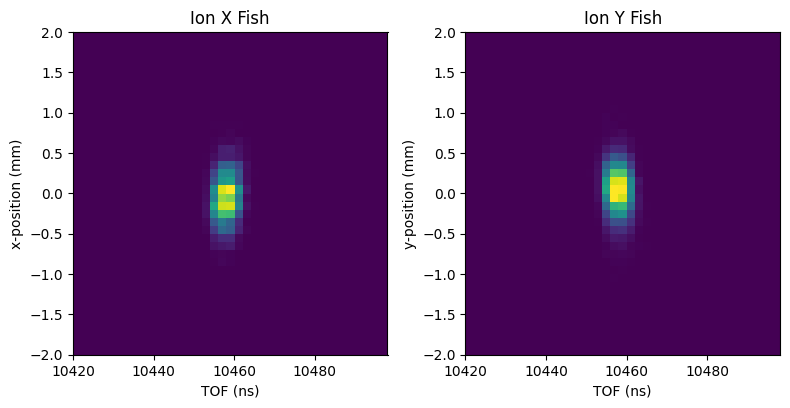

In [32]:
##########################
########## hit 1 #########
### corrected ion fish ###
##########################
fig1, (ax11, ax22) = plt.subplots(1,2,figsize=(8,6))

iTOF_edges = np.arange(10420,10500,2.0)
ix_edges = np.arange(-2,2.1,0.1)
iy_edges = np.arange(-2,2.1,0.1)

H_ix_fish, iTOF_edges, ixfish_edges = np.histogram2d(i_TOF0,i_x0,bins=(iTOF_edges,ix_edges))
H_ix_fish = H_ix_fish.T

H_iy_fish, iTOF_edges, iyfish_edges = np.histogram2d(i_TOF0,i_y0,bins=(iTOF_edges,iy_edges))
H_iy_fish = H_iy_fish.T

ax11.imshow(H_ix_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], ixfish_edges[0], ixfish_edges[-1]],aspect = 80/4,cmap='viridis')
ax11.set_title('Ion X Fish')
ax11.set_xlabel('TOF (ns)')
ax11.set_ylabel('x-position (mm)')
ax22.imshow(H_iy_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], iyfish_edges[0], iyfish_edges[-1]],aspect = 80/4,cmap='viridis')
ax22.set_title('Ion Y Fish')
ax22.set_xlabel('TOF (ns)')
ax22.set_ylabel('y-position (mm)')

fig1.tight_layout()
fig1.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3833378874.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


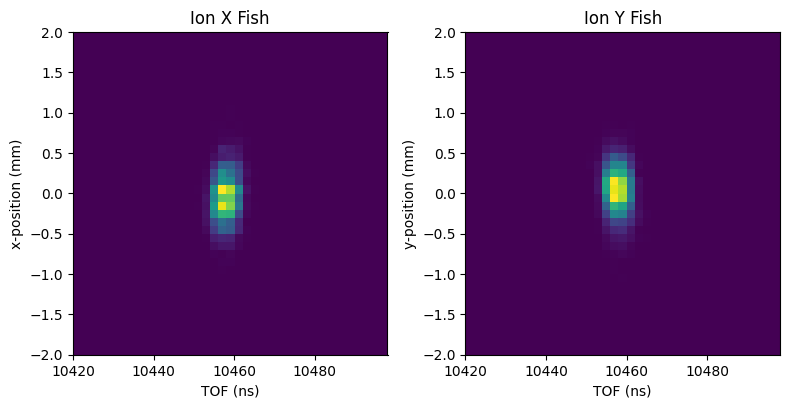

In [33]:
##########################
########## hit 2 #########
### corrected ion fish ###
##########################
fig1, (ax11, ax22) = plt.subplots(1,2,figsize=(8,6))

iTOF_edges = np.arange(10420,10500,2.0)
ix_edges = np.arange(-2,2.1,0.1)
iy_edges = np.arange(-2,2.1,0.1)

H_ix_fish, iTOF_edges, ixfish_edges = np.histogram2d(i_TOF1,i_x1,bins=(iTOF_edges,ix_edges))
H_ix_fish = H_ix_fish.T

H_iy_fish, iTOF_edges, iyfish_edges = np.histogram2d(i_TOF1,i_y1,bins=(iTOF_edges,iy_edges))
H_iy_fish = H_iy_fish.T

ax11.imshow(H_ix_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], ixfish_edges[0], ixfish_edges[-1]],aspect = 80/4,cmap='viridis')
ax11.set_title('Ion X Fish')
ax11.set_xlabel('TOF (ns)')
ax11.set_ylabel('x-position (mm)')
ax22.imshow(H_iy_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], iyfish_edges[0], iyfish_edges[-1]],aspect = 80/4,cmap='viridis')
ax22.set_title('Ion Y Fish')
ax22.set_xlabel('TOF (ns)')
ax22.set_ylabel('y-position (mm)')

fig1.tight_layout()
fig1.show()

# Transforming from (x,y,TOF) to (px,py,pz)

### We now begin steps to convert from raw measured data to momentum distributions

In [34]:
##################################################################################
### using masses and associated TOFs to begin steps towards computing momentum ### 
##################################################################################
mass_TOF = [40,80,i_TOF_fit0,14790] #using argon mass and argon dimer mass, and corresponding TOFs
e_TOF_ = e_TOF_fit0 #fitted electron TOF peak

m_e = 9.10938291e-31 #electron mass    
q = 1.602176565e-19 #electron charge
amu = 1.660538921e-27 #kg atomic mass unit

########################################
### these are spectrometer dependent ###
########################################
L_accel_tot = 0.3033 #m, total accel spectrometer length 303.3mm
L_e_drift = 0.2056 #m, electron drift length 205.6mm

mass_charge = [mass*amu/q for mass in mass_TOF[0:2]] #mass charge ratio
TOF_scaled = [TOF*1e-9 for TOF in mass_TOF[2:]] #TOFs in ns

print(mass_charge)

[4.1457076761074703e-07, 8.291415352214941e-07]


In [35]:
###################################
### fit mass/charge against TOF ###
###################################
TOF_mass_fit = np.polyfit(np.sqrt(mass_charge),TOF_scaled,1)
TOF_mass_fit_ = np.poly1d(TOF_mass_fit)

k = TOF_mass_fit_(1)
Tio = TOF_mass_fit_(0)
e_TOF_ = e_TOF_*1e-9

########################################################
#### TOF & relationship with spectrometer geometry #####
### used to fine-tune extent of spectrometer regions ###
########################################################
a = 4 * (1 + q * e_TOF_**2 / (m_e * k**2))
b = 4 * (L_e_drift - q * e_TOF_**2 * L_accel_tot / (m_e * k**2))
c = L_e_drift**2

print(b**2-4*a*c)

0.559848259703775


In [36]:
########################################################
#### TOF & relationship with spectrometer geometry #####
### used to fine-tune extent of spectrometer regions ###
########################################################
if b**2-4*a*c<0:
    print('No solution!')
elif b**2-4*a*c == 0:
    L_e_accel_ = -b/(2*a);
    if L_e_accel_ <= 0.0502 or L_e_accel_ >= 0.150:
        print('One improper solution!')
else:
    s1 = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    s2 = (-b-np.sqrt(b**2-4*a*c))/(2*a)
    if all((s1 > 0.0502, s1 < 0.150, s2 > 0.0502, s2 < 0.150)):
        print('Two solutions')
        s1
        s2
    elif s1 > 0.0502 and s1 < 0.150:
        print('One solution')
        L_e_accel_ = s1
    elif s2 > 0.0502 and s2 < 0.150:
        print('One solution')
        L_e_accel_ = s2
    else: 
        print('Two improper solutions!')
        s1
        s2

L_e_accel_ = s1
L_ion = L_accel_tot - L_e_accel_
E = 2*L_ion/k**2
U_i = E*L_ion
U_e = E*L_e_accel_

print(U_i)
print(U_e)
print(L_ion)
print(L_e_accel_)
print(U_i/(L_ion*100))
print(U_e/(L_e_accel_*100))

One solution
319.187305026516
152.59053471328613
0.20520147717818898
0.09809852282181103
15.55482491723713
15.554824917237129


In [37]:
#########################################################
### used for calculation of ion longitudinal momentum ###
#########################################################

m_OH = 17
m_N2 = 28
m_O2 = 32
m_Ar = 40
m_Ar2 = 80
Z = 1 #charge state

L_ion = L_ion*100 #convert back to cm

Tio = Tio*1e9

In [38]:
##############################################################
### function for computing particle velocity distributions ###
##############################################################

def NEW_v(acc_1, acc_2, acc_3, acc1_length, acc2_length, acc3_length, velo, tof):

    if acc_2 != 0.0 and  acc2_length != 0.0:
        a2_term = (-np.sqrt(2.0*acc_1*acc1_length + velo**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + velo**2))/acc_2    
    elif acc2_length != 0.0 and acc_2 == 0.0:
        a2_term = acc2_length/np.sqrt(2*acc_1*acc1_length + velo**2)    
    else:
        a2_term = 0.0

    if acc_3 != 0.0 and  acc3_length != 0.0:
        a3_term = (-np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + velo**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + 2.0*acc_3*acc3_length + velo**2))/acc_3   
    elif acc3_length != 0.0 and acc_3 == 0.0:
        a3_term = acc3_length/np.sqrt(2*acc_1*acc1_length + 2*acc_2*acc2_length + velo**2)
    else:
        a3_term = 0.0

    t_function = -tof + (-velo + np.sqrt(2.0*acc_1*acc1_length + velo**2))/acc_1 + a2_term + a3_term 
    v1 = velo*(1.01)

    if acc_2 != 0.0 and  acc2_length != 0.0:
        a2_term = (-np.sqrt(2.0*acc_1*acc1_length + v1**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + v1**2))/acc_2    
    elif acc2_length != 0.0 and acc_2 == 0.0:
        a2_term = acc2_length/np.sqrt(2*acc_1*acc1_length + v1**2)   
    else:
        a2_term = 0.0

    if acc_3 != 0.0 and  acc3_length != 0.0:
        a3_term = (-np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + v1**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + 2.0*acc_3*acc3_length + v1**2))/acc_3    
    elif acc3_length != 0. and acc_3 == 0.0:
        a3_term = acc3_length/np.sqrt(2*acc_1*acc1_length + 2*acc_2*acc2_length + v1**2) 
    else:
        a3_term = 0.0

    Dt_function_dv = ( (-tof + (-v1 + np.sqrt(2.0*acc_1*acc1_length + v1**2)) / acc_1 
                        + a2_term + a3_term) - t_function ) / (v1 - velo) 
    return velo - t_function / Dt_function_dv

In [39]:
######################
####### hit 1 ########
#### calculate pz ####
######################
acc1mm = 197.3
acc2mm = 6.5 
acc3mm = 0.0
Efield1_Vpcm = U_i/19.73 
Efield2_Vpcm = 2450/0.65 
Efield3_Vpcm = 0.0

E_Field_au_over_si =  1.0 / 5.1421e11 #au * m / V
length_au_over_m =  1.0 / 5.2917720859e-11  #au / m
time_au_over_s = 1.0 / 2.418884326505e-17 #au / s
AUmass_over_AMU = 1.660538782e-27 / 9.10938215e-31 #(au / kg) * (kg / amu)

t = np.zeros((len(i_TOF0),1))
mass = np.zeros((1,1)) 
q = np.zeros((1,1))
acc1 = np.zeros((1,1)) 
acc2 = np.zeros((1,1))
acc3 = np.zeros((1,1))
acc1_temp = np.ones((1,1))*0.001 
acc2_temp = np.ones((1,1))*0.001 
acc3_temp = np.ones((1,1))*0.001
v = np.zeros((len(i_TOF0),2))

#convert to AU units
t[:,0] = (i_TOF0 * 1e-9) * time_au_over_s
mass[:,0] = m_Ar *  AUmass_over_AMU
q[:,0] = 1 
acc1_length = acc1mm * 0.001 * length_au_over_m
acc2_length = acc2mm * 0.001 * length_au_over_m
acc3_length = acc3mm * 0.001 * length_au_over_m
Efield1_Vau = Efield1_Vpcm * 100.0 * E_Field_au_over_si
Efield2_Vau = Efield2_Vpcm * 100.0 * E_Field_au_over_si
Efield3_Vau = Efield3_Vpcm * 100.0 * E_Field_au_over_si

acc1[:,0] = (Efield1_Vau * q[:,0]) / mass[:,0]
acc2[:,0] = (Efield2_Vau * q[:,0]) / mass[:,0]
acc3[:,0] = (Efield3_Vau * q[:,0]) / mass[:,0]

if acc1[:,0] != 0:
    acc1_temp[:,0] = acc1[:,0]
if acc2[:,0] != 0:
    acc2_temp[:,0] = acc2[:,0]
if acc3[:,0] != 0:
    acc3_temp[:,0] = acc3[:,0]
        
v[:,0] = np.array(np.sqrt(2.0)*np.sqrt(acc1_temp[:,0]*acc1_length) -
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length))/acc2_temp[:,0] +
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length + acc2_temp[:,0]*acc2_length))/acc2_temp[:,0] - 
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length + acc2_temp[:,0]*acc2_length))/acc3_temp[:,0] +
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length + acc2_temp[:,0]*acc2_length + acc3_temp[:,0]*acc3_length))/acc3_temp[:,0] -
        acc1_temp[:,0]*t[:,0])

for i in range(0,len(i_TOF0)):
    new_v = 0.0
    shift_counter = 1
    for j in range(0,50):
        new_v = NEW_v(acc1[:,0], acc2[:,0], acc3[:,0], acc1_length, acc2_length, acc3_length, v[i,0], t[i,0])
            
        if np.isinf(new_v) == 1:
            new_v = v[i,0] * (1.0 + 2.0**shift_counter / 1000.0) #move it, at first just a little bit but increase the size of the shift until you get a finite value for the new_v
            shift_counter += 1
                
        else:
            shift_counter = 1 #reset the shift counter when you get a finite value for new_v
            
        if np.abs((new_v * mass[:,0]  - v[i,0] * mass[:,0]) / (v[i,0] * mass[:,0])) < 1e-6:
            break #exiting the loop once we've converged
            
        v[i,0] = new_v

p_z_Ar0 = v[:,0] * mass[:,0]

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2409966096.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,0] = new_v


In [40]:
######################
####### hit 2 ########
#### calculate pz ####
######################

t = np.zeros((len(i_TOF1),1))
mass = np.zeros((1,1)) 
q = np.zeros((1,1))
acc1 = np.zeros((1,1)) 
acc2 = np.zeros((1,1))
acc3 = np.zeros((1,1))
acc1_temp = np.ones((1,1))*0.001 
acc2_temp = np.ones((1,1))*0.001 
acc3_temp = np.ones((1,1))*0.001
v = np.zeros((len(i_TOF1),2))

#convert to AU units
t[:,0] = (i_TOF1 * 1e-9) * time_au_over_s
mass[:,0] = m_Ar *  AUmass_over_AMU
q[:,0] = 1 
acc1_length = acc1mm * 0.001 * length_au_over_m
acc2_length = acc2mm * 0.001 * length_au_over_m
acc3_length = acc3mm * 0.001 * length_au_over_m
Efield1_Vau = Efield1_Vpcm * 100.0 * E_Field_au_over_si
Efield2_Vau = Efield2_Vpcm * 100.0 * E_Field_au_over_si
Efield3_Vau = Efield3_Vpcm * 100.0 * E_Field_au_over_si

acc1[:,0] = (Efield1_Vau * q[:,0]) / mass[:,0]
acc2[:,0] = (Efield2_Vau * q[:,0]) / mass[:,0]
acc3[:,0] = (Efield3_Vau * q[:,0]) / mass[:,0]

if acc1[:,0] != 0:
    acc1_temp[:,0] = acc1[:,0]
if acc2[:,0] != 0:
    acc2_temp[:,0] = acc2[:,0]
if acc3[:,0] != 0:
    acc3_temp[:,0] = acc3[:,0]
        
v[:,0] = np.array(np.sqrt(2.0)*np.sqrt(acc1_temp[:,0]*acc1_length) -
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length))/acc2_temp[:,0] +
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length + acc2_temp[:,0]*acc2_length))/acc2_temp[:,0] - 
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length + acc2_temp[:,0]*acc2_length))/acc3_temp[:,0] +
        (np.sqrt(2.0)*acc1_temp[:,0]*np.sqrt(acc1_temp[:,0]*acc1_length + acc2_temp[:,0]*acc2_length + acc3_temp[:,0]*acc3_length))/acc3_temp[:,0] -
        acc1_temp[:,0]*t[:,0])

for i in range(0,len(i_TOF1)):
    new_v = 0.0
    shift_counter = 1
    for j in range(0,50):
        new_v = NEW_v(acc1[:,0], acc2[:,0], acc3[:,0], acc1_length, acc2_length, acc3_length, v[i,0], t[i,0])
            
        if np.isinf(new_v) == 1:
            new_v = v[i,0] * (1.0 + 2.0**shift_counter / 1000.0) #move it, at first just a little bit but increase the size of the shift until you get a finite value for the new_v
            shift_counter += 1
                
        else:
            shift_counter = 1 #reset the shift counter when you get a finite value for new_v
            
        if np.abs((new_v * mass[:,0]  - v[i,0] * mass[:,0]) / (v[i,0] * mass[:,0])) < 1e-6:
            break #exiting the loop once we've converged
            
        v[i,0] = new_v

p_z_Ar1 = v[:,0] * mass[:,0]

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1674540640.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,0] = new_v


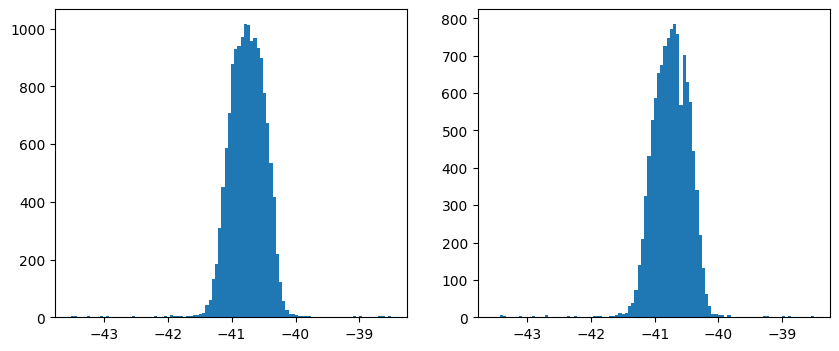

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#########################################
################# hit 1 #################
### ion momentum distribution along z ###
#########################################
ax1.hist(p_z_Ar0,bins=100)
(mu_i0_p_long0, sigma_i0_p_long0) = norm.fit(p_z_Ar0)
p_z_Ar0 = p_z_Ar0 - mu_i0_p_long0

#########################################
################# hit 2 #################
### ion momentum distribution along z ###
#########################################
ax2.hist(p_z_Ar1,bins=100)
(mu_i0_p_long1, sigma_i0_p_long1) = norm.fit(p_z_Ar1)
p_z_Ar1 = p_z_Ar1 - mu_i0_p_long1

In [42]:
###############################################
### applying offset to center properly on 0 ###
###############################################
p_z_Ar0 = [-a for a in p_z_Ar0]
p_z_Ar1 = [-a for a in p_z_Ar1]

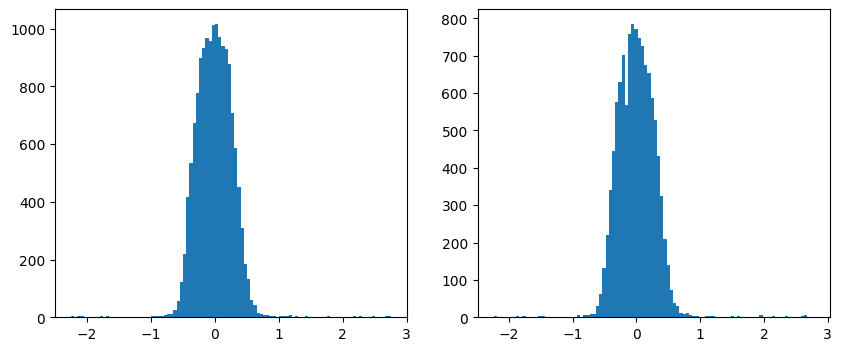

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#########################################
################# hit 1 #################
### ion momentum distribution along z ###
############ after offsetting ###########
#########################################
ax1.hist(p_z_Ar0,bins=100)
(mu_i0_p_long0, sigma_i0_p_long0) = norm.fit(p_z_Ar0)
p_z_Ar0 = p_z_Ar0 - mu_i0_p_long0

#########################################
################# hit 2 #################
### ion momentum distribution along z ###
############ after offsetting ###########
#########################################
ax2.hist(p_z_Ar1,bins=100)
(mu_i0_p_long1, sigma_i0_p_long1) = norm.fit(p_z_Ar1)
p_z_Ar1 = p_z_Ar1 - mu_i0_p_long1

In [44]:
###################################################
### computing transverse momentum distributions ###
###################################################
numerator_x0 = np.array([ix * m_Ar for ix in i_x0])
denominator0 = np.array([iTOF * 0.0012 for iTOF in i_TOF0])
numerator_y0 = np.array([iy * m_Ar for iy in i_y0])
p_x_Ar0 = np.divide(numerator_x0,denominator0)
p_y_Ar0 = np.divide(numerator_y0,denominator0)

numerator_x1 = np.array([ix * m_Ar for ix in i_x1])
denominator1 = np.array([iTOF * 0.0012 for iTOF in i_TOF1])
numerator_y1 = np.array([iy * m_Ar for iy in i_y1])
p_x_Ar1 = np.divide(numerator_x1,denominator1)
p_y_Ar1 = np.divide(numerator_y1,denominator1)

-0.14612107037218738
-0.13980552904961346


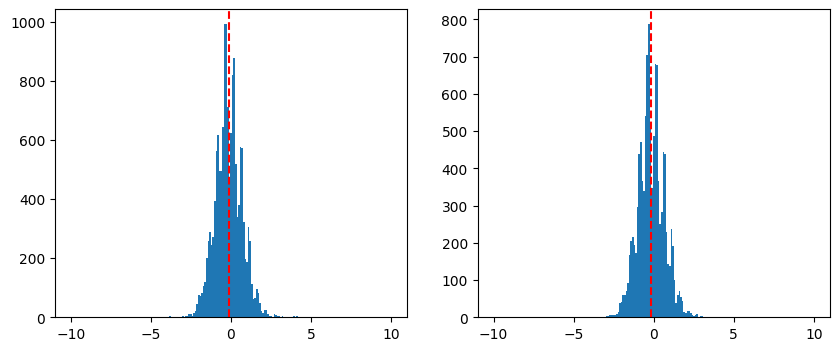

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#########################################
################# hit 1 #################
### ion momentum distribution along x ###
#########################################
p_x_Ar0_filt = [x for x in p_x_Ar0 if x < 10 and x>-10] #fit on filtered data so outliers don't drag the mean
ax1.hist(p_x_Ar0,bins=np.linspace(-10,10,200))
(mu_i0_p_x0, sigma_i0_p_x0) = norm.fit(p_x_Ar0_filt) #fit on filtered data so outliers don't drag the mean
print(mu_i0_p_x0)
ax1.axvline(mu_i0_p_x0,c='r',ls='--')
p_x_Ar0 = p_x_Ar0 - mu_i0_p_x0

#########################################
################# hit 2 #################
### ion momentum distribution along x ###
#########################################
p_x_Ar1_filt = [x for x in p_x_Ar1 if x < 10 and x>-10] #fit on filtered data so outliers don't drag the mean
ax2.hist(p_x_Ar1,bins=np.linspace(-10,10,200))
(mu_i0_p_x1, sigma_i0_p_x1) = norm.fit(p_x_Ar1_filt) #fit on filtered data so outliers don't drag the mean
print(mu_i0_p_x1)
ax2.axvline(mu_i0_p_x1,c='r',ls='--')
p_x_Ar1 = p_x_Ar1 - mu_i0_p_x1

0.14420076254577796
0.1439286682525645


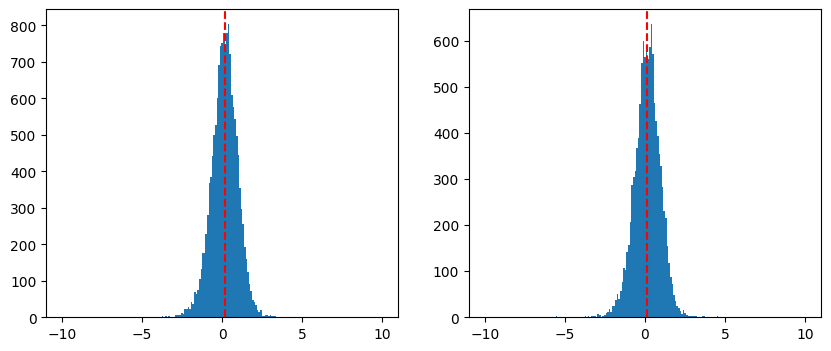

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#########################################
################# hit 1 #################
### ion momentum distribution along y ###
#########################################
p_y_Ar0_filt = [x for x in p_y_Ar0 if x < 10 and x>-10] #fit on filtered data so outliers don't drag the mean
ax1.hist(p_y_Ar0,bins=np.linspace(-10,10,200))
a,b=np.histogram(p_y_Ar0,bins=np.linspace(-10,10,200))
(mu_i0_p_y0, sigma_i0_p_y0) = norm.fit(p_y_Ar0_filt) #fit on filtered data so outliers don't drag the mean
print(mu_i0_p_y0)
ax1.axvline(mu_i0_p_y0,c='r',ls='--')
p_y_Ar0 = p_y_Ar0 - mu_i0_p_y0

#########################################
################# hit 2 #################
### ion momentum distribution along y ###
#########################################
p_y_Ar1_filt = [x for x in p_y_Ar1 if x < 10 and x>-10] #fit on filtered data so outliers don't drag the mean
ax2.hist(p_y_Ar1,bins=np.linspace(-10,10,200))
(mu_i0_p_y1, sigma_i0_p_y1) = norm.fit(p_y_Ar1_filt) #fit on filtered data so outliers don't drag the mean
print(mu_i0_p_y1)
ax2.axvline(mu_i0_p_y1,c='r',ls='--')
p_y_Ar1 = p_y_Ar1 - mu_i0_p_y1

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2906300073.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


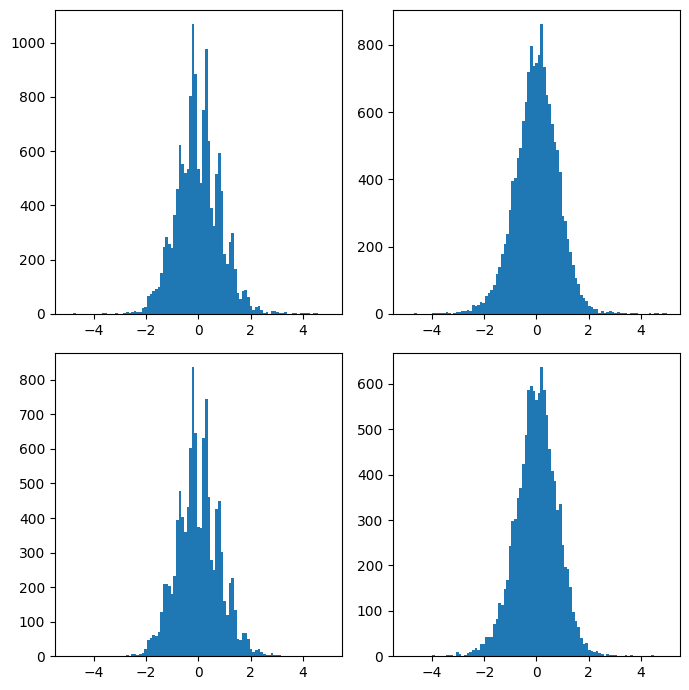

In [47]:
##################################################################
### hit 1 and 2 transverse distributions after applying offset ###
##################################################################

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax1.hist(p_x_Ar0,bins=np.linspace(-5,5,100))
ax2.hist(p_y_Ar0,bins=np.linspace(-5,5,100))
ax3.hist(p_x_Ar1,bins=np.linspace(-5,5,100))
ax4.hist(p_y_Ar1,bins=np.linspace(-5,5,100))

fig.tight_layout()
fig.show()

In [48]:
###########################
### electron parameters ###
###########################
L_e_accel_ = L_e_accel_ * 100
L_drift = 20.56 # cm - length of electron drift region
t_e_offset = 0.0 # time zero of electron
e = 1.602176565e-19 # C - elementary charge
mom_corr_e = 0.0
electron_mass =	0.0005446623 # 1/1836amu

#########################################################################
### can tweak the electric field value here to adjust the calibration ###
#########################################################################
U_e = U_e - 1.5

print(L_e_accel_)
print(L_drift)
print(U_e)

9.809852282181103
20.56
151.09053471328613


In [49]:
#############################################################
### function for computing electron longitudinal momentum ###
#############################################################
def z_momentum(z,elec_TOF,n):
    return z - (1 / (np.sqrt(z * z + 1) + z) + (0.5 * L_drift / L_e_accel_) / np.sqrt(z * z + 1) 
                - np.sqrt(U_e) * (elec_TOF[n] - t_e_offset) / (2 * L_e_accel_ * np.sqrt(electron_mass) 
                * 722.6))/((-1 / np.sqrt(z * z + 1)) * (1 / (z + np.sqrt(z * z + 1))
                + (z * 0.5 * L_drift / L_e_accel_) / (1 + z * z))) 

In [50]:
################################################
#################### hit 1 #####################
### calculate longitudinal electron momentum ###
################################################
e_pz0 = []
for i in range(0,len(e_TOF0)): 
    z = -1;
    for n in range(0,5):
        z = z_momentum(z,e_TOF0,i)
    e_pz0.append(z * np.sqrt(U_e/13.6057) - mom_corr_e) ###HYDROGEN GROUND STATE E 13.6057

In [51]:
################################################
#################### hit 2 #####################
### calculate longitudinal electron momentum ###
################################################
e_pz1 = []
for i in range(0,len(e_TOF1)): 
    z = -1;
    for n in range(0,5):
        z = z_momentum(z,e_TOF1,i)
    e_pz1.append(z * np.sqrt(U_e/13.6057) - mom_corr_e) ###HYDROGEN GROUND STATE E 13.6057

0.034486445157552496
-0.049497172555666664


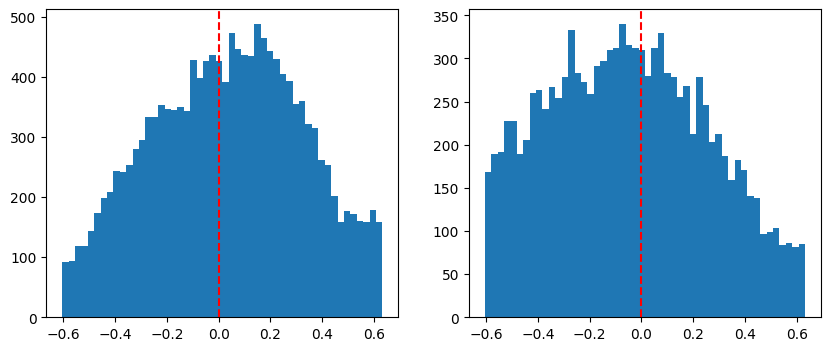

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

######################################
############### hit 1 ################
### longitudinal electron momentum ###
######################################
(mu_e_p_long0, sigma_e_p_long0) = norm.fit(e_pz0)
print(mu_e_p_long0)
ax1.hist(e_pz0,bins=50)
ax1.axvline(0,c='r',ls='--')

######################################
############### hit 2 ################
### longitudinal electron momentum ###
######################################
(mu_e_p_long1, sigma_e_p_long1) = norm.fit(e_pz1)
print(mu_e_p_long1)
ax2.hist(e_pz1,bins=50)
ax2.axvline(0,c='r',ls='--')

In [53]:
###################################################
###################### hit 1 ######################
### calculation of transverse electron momentum ###
###################################################

cyc_per = 95.5 #determined from node separation in wiggle spectrum

e_rad__0 = []
e_p_transverse0 = []
e_phi0 =  []
e_px0 =  []
e_py0 =  []
e_wt_angle0 =  []
e_eff_angle0 =  []

for i in range(0,len(e_TOF0)):
    
    e_rad__0.append(e_rad0[i]/(2 * np.abs(np.sin(np.pi/cyc_per * (e_TOF0[i] - t_e_offset)))))
    e_p_transverse0.append(e_rad__0[i] * 2 * np.pi/cyc_per * 2.419/5.292) ##### 5.292 BOHR RADIUS, 2.419 1 A.U. OF TIME #####
    e_wt_angle0.append(2 * np.pi * (e_TOF0[i] - t_e_offset) / cyc_per)
    e_eff_angle0.append(e_wt_angle0[i] - np.floor(e_wt_angle0[i] / (2*np.pi)) * 2*np.pi)
    e_phi0.append(-((np.arctan2(e_y0[i],e_x0[i])) + e_eff_angle0[i]/2))
    
    if e_phi0[i] < 0:
        e_phi0[i] = e_phi0[i] + 2*np.pi    
    if e_phi0[i] > 2*np.pi:
        e_phi0[i] = e_phi0[i] - 2*np.pi
        
    e_px0.append(np.cos(e_phi0[i]) * e_p_transverse0[i])
    e_py0.append(np.sin(e_phi0[i]) * e_p_transverse0[i])

In [54]:
###################################################
###################### hit 2 ######################
### calculation of transverse electron momentum ###
###################################################

cyc_per = 95.5 #determined from node separation in wiggle spectrum

e_rad__1 = []
e_p_transverse1 = []
e_phi1 =  []
e_px1 =  []
e_py1 =  []
e_wt_angle1 =  []
e_eff_angle1 =  []

for i in range(0,len(e_TOF1)):
    
    e_rad__1.append(e_rad1[i]/(2 * np.abs(np.sin(np.pi/cyc_per * (e_TOF1[i] - t_e_offset)))))
    e_p_transverse1.append(e_rad__1[i] * 2 * np.pi/cyc_per * 2.419/5.292) ##### 5.292 BOHR RADIUS, 2.419 1 A.U. OF TIME #####
    e_wt_angle1.append(2 * np.pi * (e_TOF1[i] - t_e_offset) / cyc_per)
    e_eff_angle1.append(e_wt_angle1[i] - np.floor(e_wt_angle1[i] / (2*np.pi)) * 2*np.pi)
    e_phi1.append(-((np.arctan2(e_y1[i],e_x1[i])) + e_eff_angle1[i]/2))
    
    if e_phi1[i] < 0:
        e_phi1[i] = e_phi1[i] + 2*np.pi    
    if e_phi1[i] > 2*np.pi:
        e_phi1[i] = e_phi1[i] - 2*np.pi
        
    e_px1.append(np.cos(e_phi1[i]) * e_p_transverse1[i])
    e_py1.append(np.sin(e_phi1[i]) * e_p_transverse1[i])

# Now we enforce gates in momentum space on data to select channels and events of interest

### First we gate on electrons using two shells of different radius in momentum space, only accepting events which lie between. We then apply another gate that enforces momentum conservation between the electron-ion pair (longitudinal). Finally we gate on ion trasverse distributions.

In [55]:
######################
####### hit 1 ########
### applying gates ###
######################

data0 = list(zip(e_px0, e_py0, e_pz0, p_x_Ar0, p_y_Ar0, p_z_Ar0))

good_events0 = []
for event in data0:
    epx, epy, epz, ipx, ipy, ipz = event[0], event[1], event[2], event[3], event[4], event[5]
    if epx**2 + epy**2 + epz**2 <= 0.51**2 and epx**2 + epy**2 + epz**2 >= 0.38**2: #electron momentum space gate
        if ipz + epz >= -0.25 and ipz + epz <= 0.225: #momentum conservation gate
            if all((ipx > -10.0, ipx < 10.0, ipy > -10.0, ipy < 10.0)): #ion transverse momentum gate
                good_events0.append(event)
        
good_events0 = list(zip(*good_events0))

In [56]:
######################
####### hit 2 ########
### applying gates ###
######################

data1 = list(zip(e_px1, e_py1, e_pz1, p_x_Ar1, p_y_Ar1, p_z_Ar1))

good_events1 = []
for event in data1:
    epx, epy, epz, ipx, ipy, ipz = event[0], event[1], event[2], event[3], event[4], event[5]
    if epx**2 + epy**2 + epz**2 <= 0.51**2 and epx**2 + epy**2 + epz**2 >= 0.38**2: #electron momentum space gate
        if ipz + epz >= -0.225 and ipz + epz <= 0.20: #momentum conservation gate
            if all((ipx > -10.0, ipx < 10.0, ipy > -10.0, ipy < 10.0)): #ion transverse momentum gate
                good_events1.append(event)
        
good_events1 = list(zip(*good_events1))

In [57]:
#####################################################################
#### offset electron momentum distributions to be centered on 0 #####
### scale ion transverse distribution to match longitudinal width ###
#################### since this axis is best res ####################
#####################################################################
e_px0 = np.array(good_events0[0])+0.010
e_py0 = np.array(good_events0[1])-0.005
e_pz0 = np.array(good_events0[2])-0.005
i_px0 = np.array(good_events0[3])*0.3
i_py0 = np.array(good_events0[4])*0.3
i_pz0 = np.array(good_events0[5])

In [58]:
#####################################################################
#### offset electron momentum distributions to be centered on 0 #####
### scale ion transverse distribution to match longitudinal width ###
#################### since this axis is best res ####################
#####################################################################
e_px1 = np.array(good_events1[0])+0.010
e_py1 = np.array(good_events1[1])-0.005
e_pz1 = np.array(good_events1[2])-0.005
i_px1 = np.array(good_events1[3])*0.3
i_py1 = np.array(good_events1[4])*0.3
i_pz1 = np.array(good_events1[5])

### Applying some more gentle gates on momentum conservation between electron-ion pair (trasverse). Resolution along this axis is worse, so we can not gate as strictly.

In [59]:
data00 = list(zip(e_px0, e_py0, e_pz0, i_px0, i_py0, i_pz0))

good_events00 = []
for event in data00:
    epx, epy, epz, ipx, ipy, ipz = event[0], event[1], event[2], event[3], event[4], event[5]
    if ipy < -0.15*epy + 0.5 and ipy > -0.15*epy - 0.5: #momentum conservation, transverse
        if ipx < -0.15*epx + 0.5 and ipx > -0.15*epx - 0.5: #momentum conservation, transverse
            good_events00.append(event)
        
good_events00 = list(zip(*good_events00))

In [60]:
data11 = list(zip(e_px1, e_py1, e_pz1, i_px1, i_py1, i_pz1))

good_events11 = []
for event in data11:
    epx, epy, epz, ipx, ipy, ipz = event[0], event[1], event[2], event[3], event[4], event[5]
    if ipy < -0.15*epy + 0.5 and ipy > -0.15*epy - 0.5: #momentum conservation, transverse
        if ipx < -0.15*epx + 0.5 and ipx > -0.15*epx - 0.5: #momentum conservation, transverse
            good_events11.append(event)
        
good_events11 = list(zip(*good_events11))

In [61]:
e_px0 = np.array(good_events00[0])
e_py0 = np.array(good_events00[1])
e_pz0 = np.array(good_events00[2])
i_px0 = np.array(good_events00[3])
i_py0 = np.array(good_events00[4])
i_pz0 = np.array(good_events00[5])

In [62]:
e_px1 = np.array(good_events11[0])
e_py1 = np.array(good_events11[1])
e_pz1 = np.array(good_events11[2])
i_px1 = np.array(good_events11[3])
i_py1 = np.array(good_events11[4])
i_pz1 = np.array(good_events11[5])

In [63]:
#####################################################
### how many events we have left over after gates ###
#####################################################
print(len(e_px0))
print(len(e_px1))

6408
2506


In [64]:
###################################################
### rotate the momentum sphere about the y-axis ### 
############## to correct for BF tip ##############
################## [cos   0  sin] #################
################## [ 0    1   0 ] #################
################## [-sin  0  cos] #################
###################################################

BF_angle = 2.0*np.pi/180 #back-focusing mirror angle

e_px0 = e_px0*np.cos(BF_angle) + e_pz0*np.sin(BF_angle)
e_py0 = e_py0
e_pz0 = -e_px0*np.sin(BF_angle) + e_pz0*np.cos(BF_angle)

e_px1 = e_px1*np.cos(BF_angle) + e_pz1*np.sin(BF_angle)
e_py1 = e_py1
e_pz1 = -e_px1*np.sin(BF_angle) + e_pz1*np.cos(BF_angle)

In [65]:
###################################################
### rotate the momentum sphere about the x-axis ###
####### to correct for tipped polarization ########
################## [1   0    0 ] ##################
################## [0  cos -sin] ##################
################## [0  sin  cos] ##################
###################################################

VUV_angle = -2.0*np.pi/90 #VUV polarization angle

e_px0 = e_px0
e_py0 = e_py0*np.cos(VUV_angle) - e_pz0*np.sin(VUV_angle)
e_pz0 = e_py0*np.sin(VUV_angle) + e_pz0*np.cos(VUV_angle)

e_px1 = e_px1
e_py1 = e_py1*np.cos(VUV_angle) - e_pz1*np.sin(VUV_angle)
e_pz1 = e_py1*np.sin(VUV_angle) + e_pz1*np.cos(VUV_angle)

In [66]:
############################################################
### offsetting ion momentum distributions one final time ###
###### after applying gates and eliminating pollution ######
############################################################

(mu_ix0, sigma_ix0) = norm.fit(i_px0)
i_px_offset_0 = mu_ix0

(mu_iy0, sigma_iy0) = norm.fit(i_py0)
i_py_offset_0 = mu_iy0

(mu_iz0, sigma_iz0) = norm.fit(i_pz0)
i_pz_offset_0 = mu_iz0

i_px0 = i_px0 - i_px_offset_0
i_py0 = i_py0 - i_py_offset_0
i_pz0 = i_pz0 - i_pz_offset_0

(mu_ix1, sigma_ix1) = norm.fit(i_px1)
i_px_offset_1 = mu_ix1

(mu_iy1, sigma_iy1) = norm.fit(i_py1)
i_py_offset_1 = mu_iy1

(mu_iz1, sigma_iz1) = norm.fit(i_pz1)
i_pz_offset_1 = mu_iz1

i_px1 = i_px1 - i_px_offset_1
i_py1 = i_py1 - i_py_offset_1
i_pz1 = i_pz1 - i_pz_offset_1

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1874689255.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


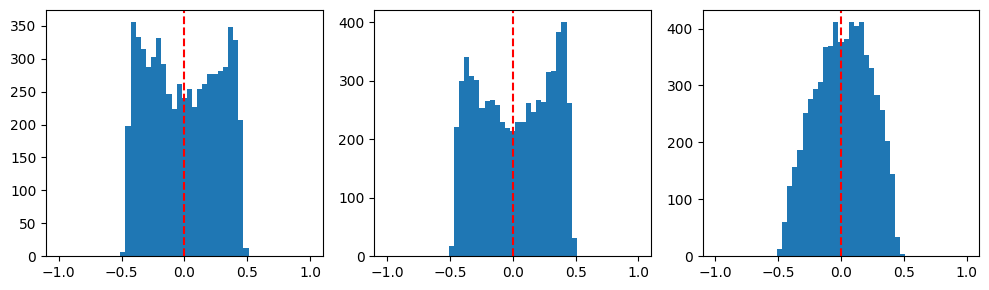

In [67]:
#############################################
### electron 1 1-D momentum distributions ###
#############################################

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.hist(e_px0, bins=np.linspace(-1,1,50))
ax1.axvline(0,c='r',ls='--')
ax2.hist(e_py0, bins=np.linspace(-1,1,50))
ax2.axvline(0,c='r',ls='--')
ax3.hist(e_pz0, bins=np.linspace(-1,1,50))
ax3.axvline(0,c='r',ls='--')
fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1775670118.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


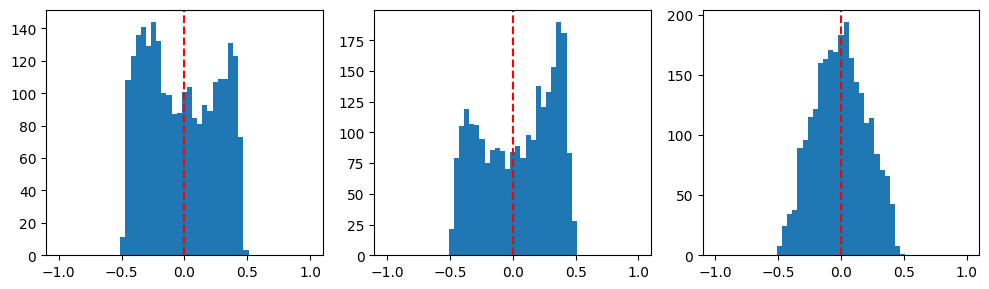

In [68]:
#############################################
### electron 2 1-D momentum distributions ###
#############################################

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.hist(e_px1, bins=np.linspace(-1,1,50))
ax1.axvline(0,c='r',ls='--')
ax2.hist(e_py1, bins=np.linspace(-1,1,50))
ax2.axvline(0,c='r',ls='--')
ax3.hist(e_pz1, bins=np.linspace(-1,1,50))
ax3.axvline(0,c='r',ls='--')
fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1432408116.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


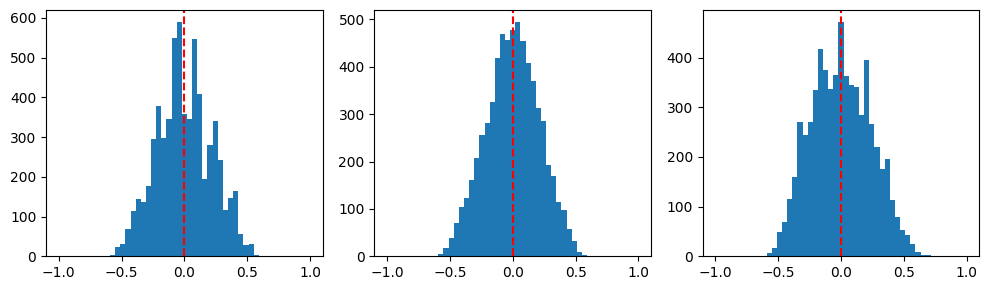

In [69]:
########################################
### ion 1 1-D momentum distributions ###
########################################

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.hist(i_px0, bins=np.linspace(-1,1,50))
ax1.axvline(0,c='r',ls='--')
ax2.hist(i_py0, bins=np.linspace(-1,1,50))
ax2.axvline(0,c='r',ls='--')
ax3.hist(i_pz0, bins=np.linspace(-1,1,50))
ax3.axvline(0,c='r',ls='--')
fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/602281415.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


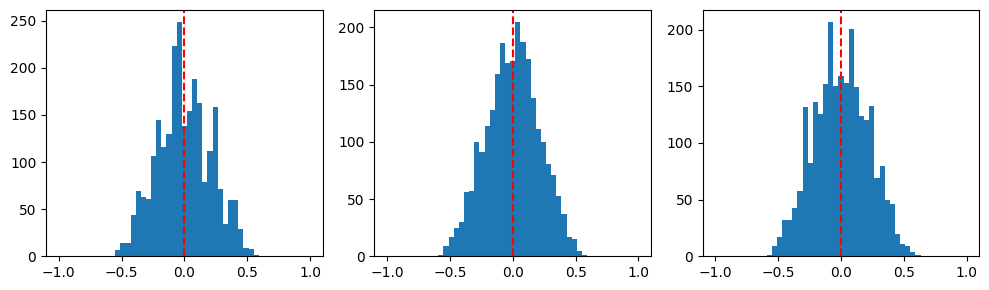

In [70]:
########################################
### ion 2 1-D momentum distributions ###
########################################

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
ax1.hist(i_px1, bins=np.linspace(-1,1,50))
ax1.axvline(0,c='r',ls='--')
ax2.hist(i_py1, bins=np.linspace(-1,1,50))
ax2.axvline(0,c='r',ls='--')
ax3.hist(i_pz1, bins=np.linspace(-1,1,50))
ax3.axvline(0,c='r',ls='--')
fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2777585638.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


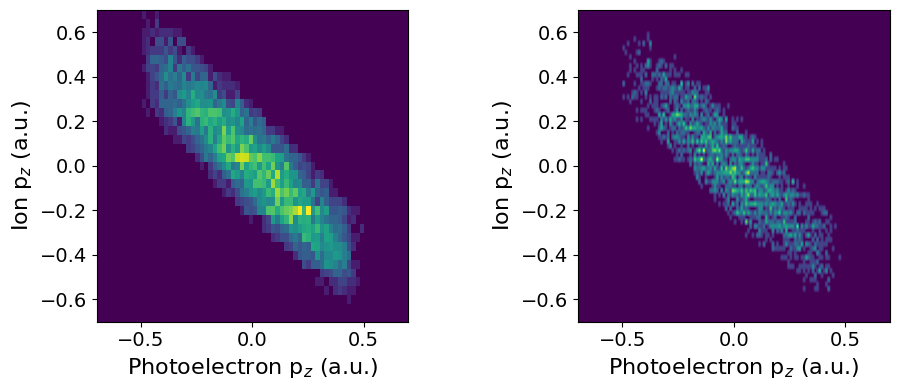

In [71]:
fig_a, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#################################
### electron 1 pz vs ion 1 pz ###
#################################

p_ez_edges = np.arange(-0.7,0.72,0.02)
p_iz_edges = np.arange(-0.7,0.74,0.04)
H_epz_ipz0, p_ez_edges, p_iz_edges = np.histogram2d(e_pz0,i_pz0,bins=(p_ez_edges,p_iz_edges))
H_epz_ipz0 = H_epz_ipz0.T

ax1.imshow(H_epz_ipz0, origin='lower', extent=[p_ez_edges[0], p_ez_edges[-1], p_iz_edges[0], p_iz_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 2 / 3))
ax1.set_xlabel('Photoelectron p$_{z}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('Ion p$_{z}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=14)

#################################
### electron 2 pz vs ion 2 pz ###
#################################

p_ez_edges = np.arange(-0.7,0.71,0.01)
p_iz_edges = np.arange(-0.7,0.72,0.02)
H_epz_ipz1, p_ez_edges, p_iz_edges = np.histogram2d(e_pz1,i_pz1,bins=(p_ez_edges,p_iz_edges))
H_epz_ipz1 = H_epz_ipz1.T

ax2.imshow(H_epz_ipz1, origin='lower', extent=[p_ez_edges[0], p_ez_edges[-1], p_iz_edges[0], p_iz_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 3 / 4))
ax2.set_xlabel('Photoelectron p$_{z}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.set_ylabel('Ion p$_{z}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.tick_params(labelsize=14)

fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/768651966.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


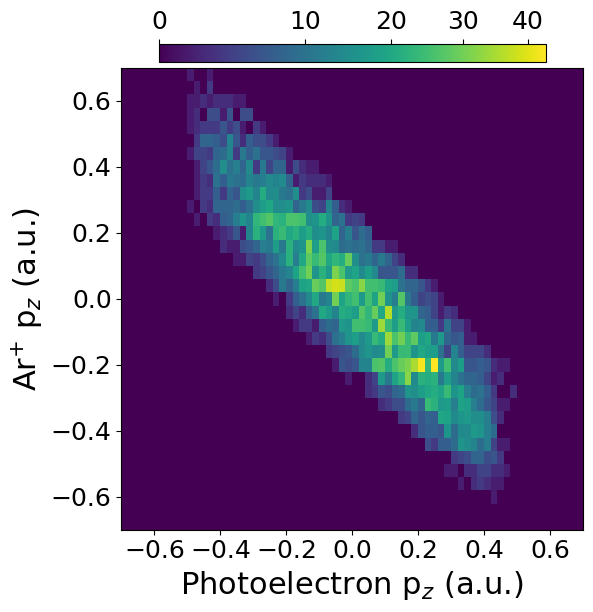

In [72]:
#################################
### electron 1 pz vs ion 1 pz ###
#################################

p_ez_edges = np.arange(-0.7,0.72,0.02)
p_iz_edges = np.arange(-0.7,0.74,0.04)
H_epz_ipz, p_ez_edges, p_iz_edges = np.histogram2d(e_pz0,i_pz0,bins=(p_ez_edges,p_iz_edges))
H_epz_ipz = H_epz_ipz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(6,6))

im = ax_a.imshow(H_epz_ipz, origin='lower', extent=[p_ez_edges[0], p_ez_edges[-1], p_iz_edges[0], p_iz_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 2 / 3))
ax_a.set_xlabel('Photoelectron p$_{z}$ (a.u.)', fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('Ar$^{+}$ p$_{z}$ (a.u.)', fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=18)

ax_a.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/315291124.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


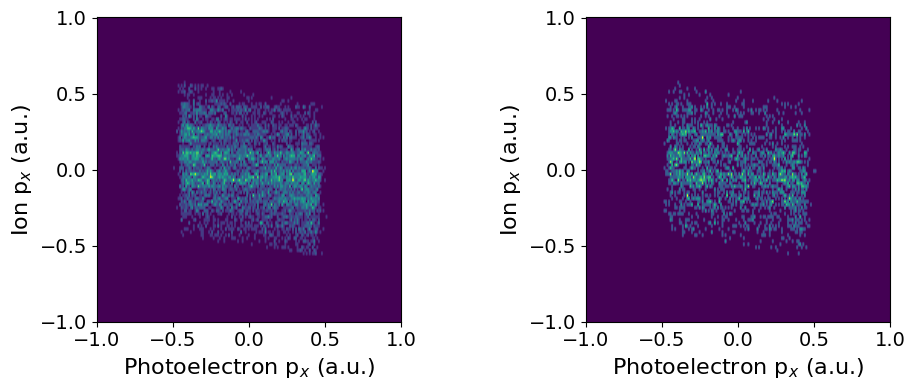

In [73]:
fig_a, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#################################
### electron 1 px vs ion 1 px ###
#################################

p_ex_edges = np.arange(-1.0,1.01,0.01)
p_ix_edges = np.arange(-1.0,1.02,0.02)
H_epx_ipx0, p_ex_edges, p_ix_edges = np.histogram2d(e_px0,i_px0,bins=(p_ex_edges,p_ix_edges))
H_epx_ipx0 = H_epx_ipx0.T

ax1.imshow(H_epx_ipx0, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ix_edges[0], p_ix_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 3 / 4))
ax1.set_xlabel('Photoelectron p$_{x}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('Ion p$_{x}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=14)

#################################
### electron 2 px vs ion 2 px ###
#################################

p_ex_edges = np.arange(-1.0,1.01,0.01)
p_ix_edges = np.arange(-1.0,1.02,0.02)
H_epx_ipx1, p_ex_edges, p_ix_edges = np.histogram2d(e_px1,i_px1,bins=(p_ex_edges,p_ix_edges))
H_epx_ipx1 = H_epx_ipx1.T

ax2.imshow(H_epx_ipx1, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ix_edges[0], p_ix_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 3 / 4))
ax2.set_xlabel('Photoelectron p$_{x}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.set_ylabel('Ion p$_{x}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.tick_params(labelsize=14)

fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1975371362.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


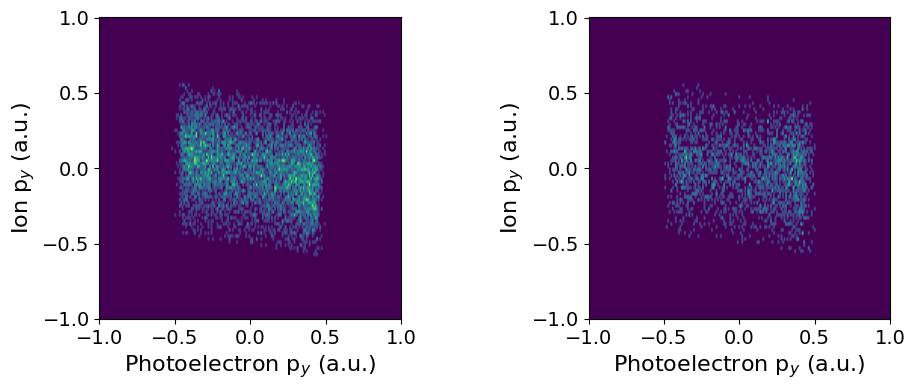

In [74]:
fig_a, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

#################################
### electron 1 py vs ion 1 py ###
#################################

p_ey_edges = np.arange(-1.0,1.01,0.01)
p_iy_edges = np.arange(-1.0,1.02,0.02)
H_epy_ipy0, p_ey_edges, p_iy_edges = np.histogram2d(e_py0,i_py0,bins=(p_ey_edges,p_iy_edges))
H_epy_ipy0 = H_epy_ipy0.T

ax1.imshow(H_epy_ipy0, origin='lower', extent=[p_ey_edges[0], p_ey_edges[-1], p_iy_edges[0], p_iy_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 3 / 4))
ax1.set_xlabel('Photoelectron p$_{y}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('Ion p$_{y}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=14)

#################################
### electron 2 py vs ion 2 py ###
#################################

p_ey_edges = np.arange(-1.0,1.01,0.01)
p_iy_edges = np.arange(-1.0,1.02,0.02)
H_epy_ipy1, p_ey_edges, p_iy_edges = np.histogram2d(e_py1,i_py1,bins=(p_ey_edges,p_iy_edges))
H_epy_ipy1 = H_epy_ipy1.T

ax2.imshow(H_epy_ipy1, origin='lower', extent=[p_ey_edges[0], p_ey_edges[-1], p_iy_edges[0], p_iy_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 3 / 4))
ax2.set_xlabel('Photoelectron p$_{y}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.set_ylabel('Ion p$_{y}$ (a.u.)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.tick_params(labelsize=14)

fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/4225302021.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


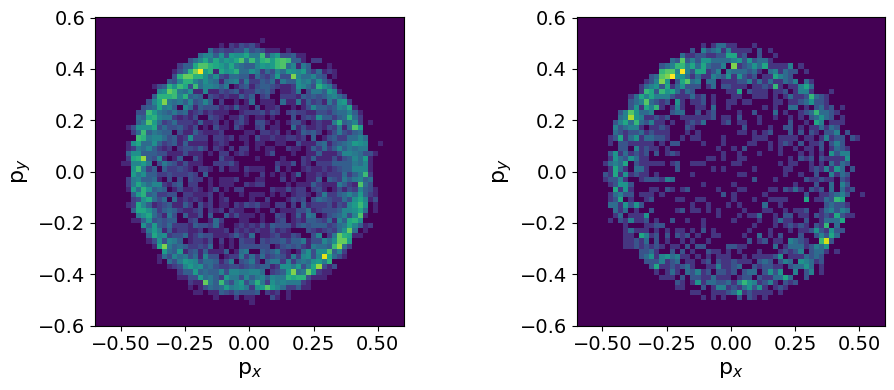

In [75]:
fig_a, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###########################
### electron 1 px vs py ###
###########################

p_ex_edges = np.arange(-0.6,0.62,0.02)
p_ey_edges = np.arange(-0.6,0.62,0.02)
H_e_px_py0, p_ex_edges, p_ey_edges = np.histogram2d(e_px0,e_py0,bins=(p_ex_edges,p_ey_edges))
H_e_px_py0 = H_e_px_py0.T

ax1.imshow(H_e_px_py0, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ey_edges[0], p_ey_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 3 / 4))
ax1.set_xlabel('p$_{x}$', fontsize=16)
ax1.set_ylabel('p$_{y}$', fontsize=16)
ax1.tick_params(labelsize=14)

###########################
### electron 2 px vs py ###
###########################

p_ex_edges = np.arange(-0.6,0.62,0.02)
p_ey_edges = np.arange(-0.6,0.62,0.02)
H_e_px_py1, p_ex_edges, p_ey_edges = np.histogram2d(e_px1,e_py1,bins=(p_ex_edges,p_ey_edges))
H_e_px_py1 = H_e_px_py1.T

ax2.imshow(H_e_px_py1, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ey_edges[0], p_ey_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 3 / 4))
ax2.set_xlabel('p$_{x}$', fontsize=16)
ax2.set_ylabel('p$_{y}$', fontsize=16)
ax2.tick_params(labelsize=14)

fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/4290143128.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


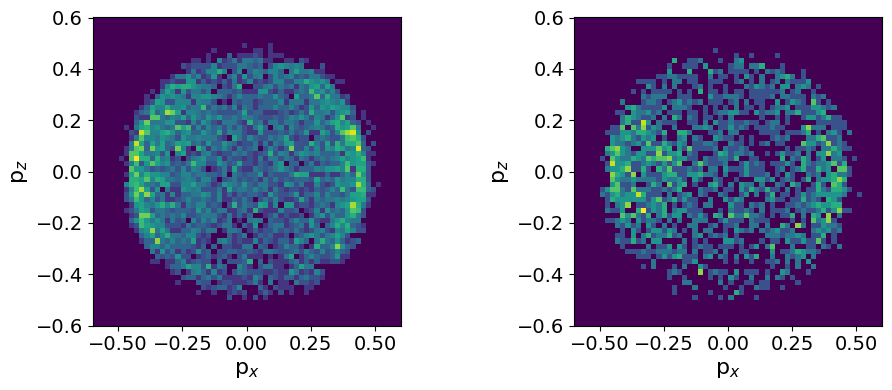

In [76]:
fig_a, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###########################
### electron 1 px vs pz ###
###########################

p_ex_edges = np.arange(-0.6,0.62,0.02)
p_ez_edges = np.arange(-0.6,0.62,0.02)
H_e_px_pz0, p_ex_edges, p_ez_edges = np.histogram2d(e_px0,e_pz0,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz0 = H_e_px_pz0.T

ax1.imshow(H_e_px_pz0, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 2 / 3))
ax1.set_xlabel('p$_{x}$', fontsize=16)
ax1.set_ylabel('p$_{z}$', fontsize=16)
ax1.tick_params(labelsize=14)

###########################
### electron 2 px vs pz ###
###########################

p_ex_edges = np.arange(-0.6,0.62,0.02)
p_ez_edges = np.arange(-0.6,0.62,0.02)
H_e_px_pz1, p_ex_edges, p_ez_edges = np.histogram2d(e_px1,e_pz1,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz1 = H_e_px_pz1.T

ax2.imshow(H_e_px_pz1, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 2 / 3))
ax2.set_xlabel('p$_{x}$', fontsize=16)
ax2.set_ylabel('p$_{z}$', fontsize=16)
ax2.tick_params(labelsize=14)

fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3575896421.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


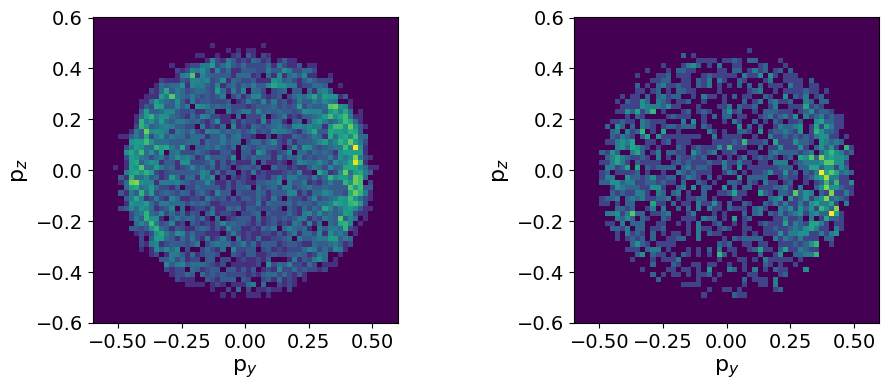

In [77]:
fig_a, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###########################
### electron 1 py vs pz ###
###########################

p_ey_edges = np.arange(-0.6,0.62,0.02)
p_ez_edges = np.arange(-0.6,0.62,0.02)
H_e_py_pz0, p_ey_edges, p_ez_edges = np.histogram2d(e_py0,e_pz0,bins=(p_ey_edges,p_ez_edges))
H_e_py_pz0 = H_e_py_pz0.T

ax1.imshow(H_e_py_pz0, origin='lower', extent=[p_ey_edges[0], p_ey_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis', norm=PowerNorm(gamma = 2 / 3))
ax1.set_xlabel('p$_{y}$', fontsize=16)
ax1.set_ylabel('p$_{z}$', fontsize=16)
ax1.tick_params(labelsize=14)

###########################
### electron 2 py vs pz ###
###########################

p_ey_edges = np.arange(-0.6,0.62,0.02)
p_ez_edges = np.arange(-0.6,0.62,0.02)
H_e_py_pz1, p_ey_edges, p_ez_edges = np.histogram2d(e_py1,e_pz1,bins=(p_ey_edges,p_ez_edges))
H_e_py_pz1 = H_e_py_pz1.T

ax2.imshow(H_e_py_pz1, origin='lower', extent=[p_ey_edges[0], p_ey_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis', norm=PowerNorm(gamma = 2 / 3))
ax2.set_xlabel('p$_{y}$', fontsize=16)
ax2.set_ylabel('p$_{z}$', fontsize=16)
ax2.tick_params(labelsize=14)

fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3762557589.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


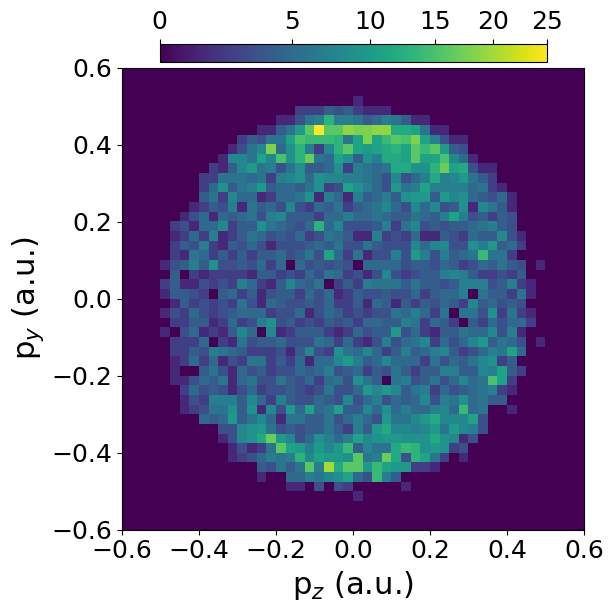

In [78]:
###########################
### electron 1 py vs pz ###
###########################

p_ex_edges = np.arange(-0.6,0.625,0.025)
p_ez_edges = np.arange(-0.6,0.625,0.025)
H_e_px_pz, p_ex_edges, p_ez_edges = np.histogram2d(e_pz0,e_py0,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz = H_e_px_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(6,6))

im = ax_a.imshow(H_e_px_pz, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',aspect=1/1,norm = PowerNorm(gamma =2 / 3))
ax_a.set_xlabel('p$_{z}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('p$_{y}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=18)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

ax_a.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2349084999.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


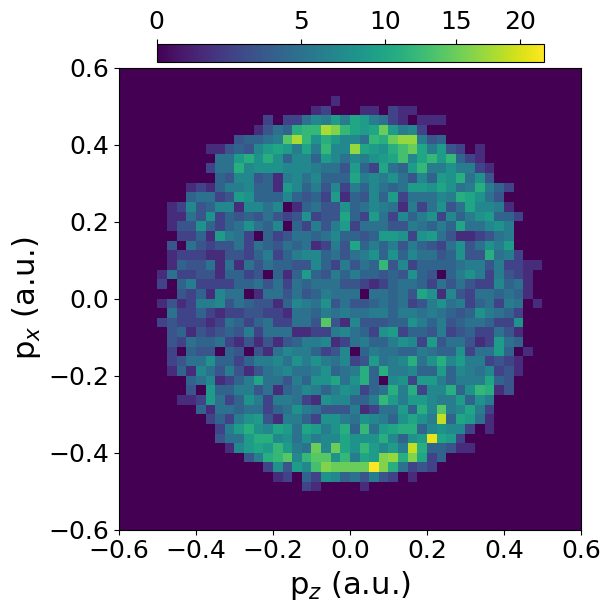

In [79]:
###########################
### electron 1 px vs pz ###
###########################

p_ex_edges = np.arange(-0.6,0.625,0.025)
p_ez_edges = np.arange(-0.6,0.625,0.025)
H_e_px_pz, p_ex_edges, p_ez_edges = np.histogram2d(e_pz0,e_px0,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz = H_e_px_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(6,6))

im = ax_a.imshow(H_e_px_pz, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',aspect=1/1,norm = PowerNorm(gamma =2 / 3))
ax_a.set_xlabel('p$_{z}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('p$_{x}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=18)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

ax_a.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3857301853.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


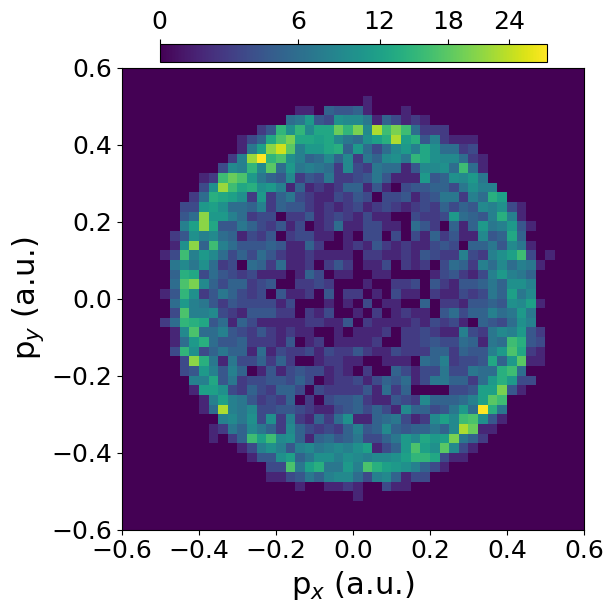

In [80]:
###########################
### electron 1 px vs py ###
###########################

p_ex_edges = np.arange(-0.6,0.625,0.025)
p_ez_edges = np.arange(-0.6,0.625,0.025)
H_e_px_pz, p_ex_edges, p_ez_edges = np.histogram2d(e_px0,e_py0,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz = H_e_px_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(6,6))

im = ax_a.imshow(H_e_px_pz, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',aspect=1/1,norm = PowerNorm(gamma =2 / 3))
ax_a.set_xlabel('p$_{x}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('p$_{y}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=18)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

ax_a.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3082459689.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_a.tight_layout()
/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3082459689.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


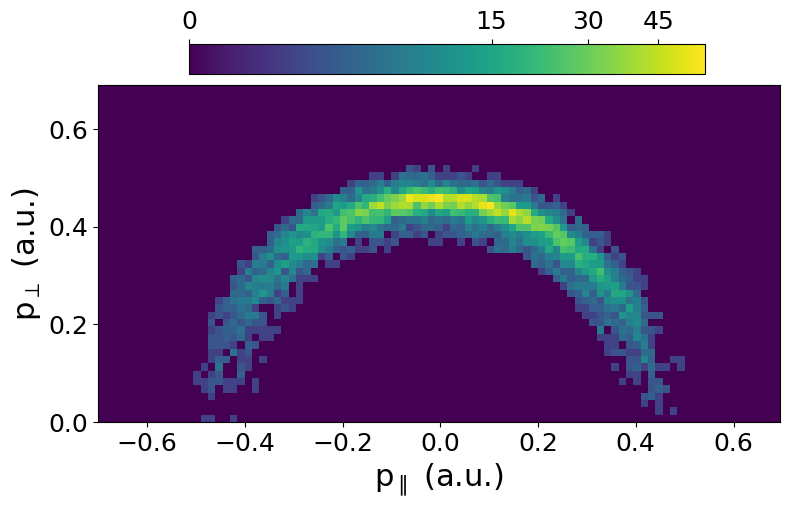

In [81]:
####################################
### electron 1 p_long vs p_trans ###
####################################

p_e_longitudinal0 = e_pz0
p_e_transverse0 = np.sqrt(e_px0**2 + e_py0**2)

p_ez_edges = np.arange(0,0.705,0.015)
p_ex_edges = np.arange(-0.7,0.705,0.015)
H_e_px_pz, p_ex_edges, p_ez_edges = np.histogram2d(p_e_longitudinal0,p_e_transverse0,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz = H_e_px_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(8,6))

im = ax_a.imshow(H_e_px_pz, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',aspect=1/1,norm = PowerNorm(gamma =1 / 2.5))
ax_a.set_ylabel('p$_{\perp}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_xlabel('p$_{\parallel}$ (a.u.)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=18)

cb_ax = fig_a.add_axes([0.2425, 0.8, 0.645, 0.05])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal',use_gridspec=True)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 18)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/871183225.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


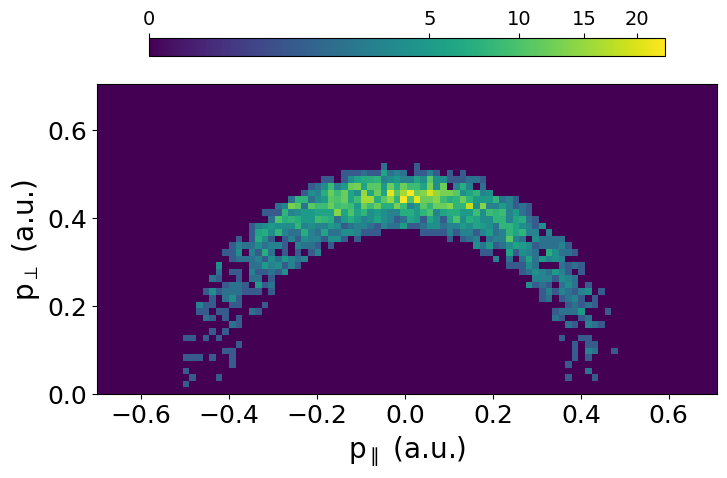

In [82]:
####################################
### electron 2 p_long vs p_trans ###
####################################

p_e_longitudinal1 = e_pz1
p_e_transverse1 = np.sqrt(e_px1**2 + e_py1**2)

p_ez_edges = np.arange(0,0.715,0.015)
p_ex_edges = np.arange(-0.7,0.715,0.015)
H_e_px_pz, p_ex_edges, p_ez_edges = np.histogram2d(p_e_longitudinal1,p_e_transverse1,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz = H_e_px_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(8,6))

im = ax_a.imshow(H_e_px_pz, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',aspect=1/1,norm = PowerNorm(gamma =1 / 2.5))
ax_a.set_ylabel('p$_{\perp}$ (a.u.)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_xlabel('p$_{\parallel}$ (a.u.)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=18)

cb_ax = fig_a.add_axes([0.19, 0.8, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 14)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

#fig_a.tight_layout()
fig_a.show()

In [83]:
e_px0 = np.array([epx for epx in e_px0])
e_py0 = np.array([epy for epy in e_py0])
e_pz0 = np.array([epz for epz in e_pz0])

e_px1 = np.array([epx for epx in e_px1])
e_py1 = np.array([epy for epy in e_py1])
e_pz1 = np.array([epz for epz in e_pz1])

In [84]:
#########################################################
### radial and angular distributions in each quadrant ###
#########################################################

rad_xy_1 = []
rad_xy_2 = []
rad_xy_3 = []
rad_xy_4 = []
for n in range(len(e_px0)):
    if e_px0[n] > 0 and e_py0[n] > 0:
        rad_xy_1.append(np.sqrt(e_px0[n]**2 + e_py0[n]**2))
    if e_px0[n] < 0 and e_py0[n] > 0:
        rad_xy_2.append(np.sqrt(e_px0[n]**2 + e_py0[n]**2))
    if e_px0[n] < 0 and e_py0[n] < 0:
        rad_xy_3.append(np.sqrt(e_px0[n]**2 + e_py0[n]**2))
    if e_px0[n] > 0 and e_py0[n] < 0:
        rad_xy_4.append(np.sqrt(e_px0[n]**2 + e_py0[n]**2))

rad_xz_1 = []
rad_xz_2 = []
rad_xz_3 = []
rad_xz_4 = []
for n in range(len(e_px0)):
    if e_px0[n] > 0 and e_pz0[n] > 0:
        rad_xz_1.append(np.sqrt(e_px0[n]**2 + e_pz0[n]**2))
    if e_px0[n] < 0 and e_pz0[n] > 0:
        rad_xz_2.append(np.sqrt(e_px0[n]**2 + e_pz0[n]**2))
    if e_px0[n] < 0 and e_pz0[n] < 0:
        rad_xz_3.append(np.sqrt(e_px0[n]**2 + e_pz0[n]**2))
    if e_px0[n] > 0 and e_pz0[n] < 0:
        rad_xz_4.append(np.sqrt(e_px0[n]**2 + e_pz0[n]**2))

rad_yz_1 = []
rad_yz_2 = []
rad_yz_3 = []
rad_yz_4 = []
for n in range(len(e_py0)):
    if e_py0[n] > 0 and e_pz0[n] > 0:
        rad_yz_1.append(np.sqrt(e_py0[n]**2 + e_pz0[n]**2))
    if e_py0[n] < 0 and e_pz0[n] > 0:
        rad_yz_2.append(np.sqrt(e_py0[n]**2 + e_pz0[n]**2))
    if e_py0[n] < 0 and e_pz0[n] < 0:
        rad_yz_3.append(np.sqrt(e_py0[n]**2 + e_pz0[n]**2))
    if e_py0[n] > 0 and e_pz0[n] < 0:
        rad_yz_4.append(np.sqrt(e_py0[n]**2 + e_pz0[n]**2))

phi_xy = np.arctan2(e_py0,e_px0)
for phi in phi_xy:
    if phi < 0.0:
        phi += 2*np.pi
        
phi_xz = np.arctan2(e_pz0,e_px0)
for phi in phi_xz:
    if phi < 0.0:
        phi += 2*np.pi
        
phi_yz = np.arctan2(e_pz0,e_py0)
for phi in phi_yz:
    if phi < 0.0:
        phi += 2*np.pi

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1875662782.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


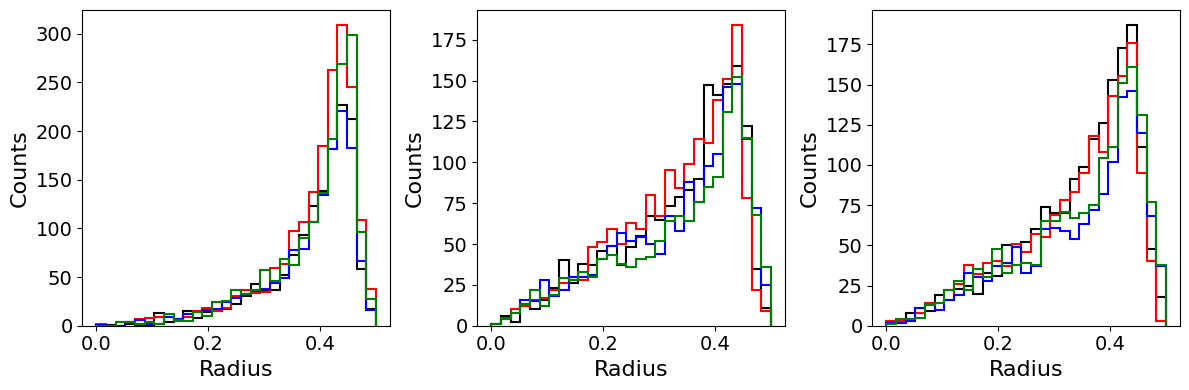

In [85]:
#####################################################
### electron radial distribution in each quadrant ###
#####################################################

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.hist(rad_xy_1,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='k')
ax1.hist(rad_xy_2,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='r')
ax1.hist(rad_xy_3,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='b')
ax1.hist(rad_xy_4,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='g')
ax1.set_xlabel('Radius', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('Counts', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=14)

ax2.hist(rad_xz_1,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='k')
ax2.hist(rad_xz_2,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='r')
ax2.hist(rad_xz_3,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='b')
ax2.hist(rad_xz_4,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='g')
ax2.set_xlabel('Radius', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.set_ylabel('Counts', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.tick_params(labelsize=14)

ax3.hist(rad_yz_1,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='k')
ax3.hist(rad_yz_2,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='r')
ax3.hist(rad_yz_3,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='b')
ax3.hist(rad_yz_4,bins=np.linspace(0,0.5,num=30),histtype='step',lw=1.5,color='g')
ax3.set_xlabel('Radius', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax3.set_ylabel('Counts', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax3.tick_params(labelsize=14)

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1924047424.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


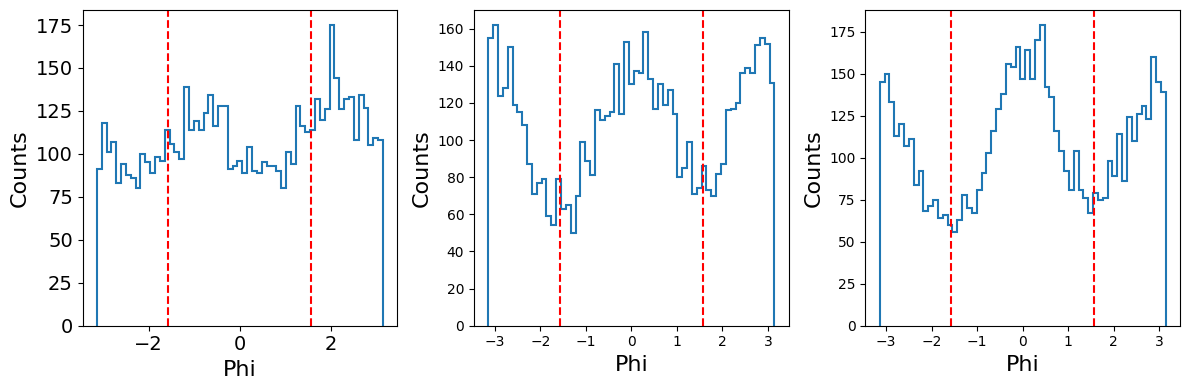

In [86]:
######################################
### electron angluar distributions ###
######################################

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

radius0, phi0, _  = ax1.hist(phi_xy,bins=np.linspace(-np.pi,np.pi,num=60),histtype='step',lw=1.5)
ax1.axvline(np.pi/2,c='r',ls='--')
ax1.axvline(-np.pi/2,c='r',ls='--')
ax1.set_xlabel('Phi', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('Counts', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=14)


radius1, phi1, _  = ax2.hist(phi_xz,bins=np.linspace(-np.pi,np.pi,num=60),histtype='step',lw=1.5)
ax2.axvline(np.pi/2,c='r',ls='--')
ax2.axvline(-np.pi/2,c='r',ls='--')
ax2.set_xlabel('Phi', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax2.set_ylabel('Counts', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=14)

radius2, phi2, _  = ax3.hist(phi_yz,bins=np.linspace(-np.pi,np.pi,num=60),histtype='step',lw=1.5)
ax3.axvline(np.pi/2,c='r',ls='--')
ax3.axvline(-np.pi/2,c='r',ls='--')
ax3.set_xlabel('Phi', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax3.set_ylabel('Counts', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.tick_params(labelsize=14)

fig.tight_layout()
fig.show()

In [87]:
########################################################
### fitting angular distributions with trig function ###
########################################################

def cosDC(x,x_off):
    return np.cos(x-x_off)**2

bincenters = 0.5*(phi0[1:]+phi0[:-1])

popt1_, pcov1_ = curve_fit(cosDC, bincenters, radius1)
popt2_, pcov2_ = curve_fit(cosDC, bincenters, radius2)

print(popt1_[0]*180/np.pi % 180)
print(popt2_[0]*180/np.pi % 180)

179.8654216098471
179.7914847520458


In [88]:
#######################################
### compute electron kinetic energy ###
#######################################

e_energy0 = 27.2114*(e_px0**2 + e_py0**2 + e_pz0**2)/2
e_energy1 = 27.2114*(e_px1**2 + e_py1**2 + e_pz1**2)/2

In [89]:
###################################################
### looking at electrons with KE less than 5 eV ###
###################################################

KEgate0 = []
for elec in e_energy0:
    if elec < 5:
        KEgate0.append(elec)
        
KEgate1 = []
for elec in e_energy1:
    if elec < 5:
        KEgate1.append(elec)

2.7850394351380476
0.3080070178746256
2.7834321636215766
0.3876813720703952


/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/355887666.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


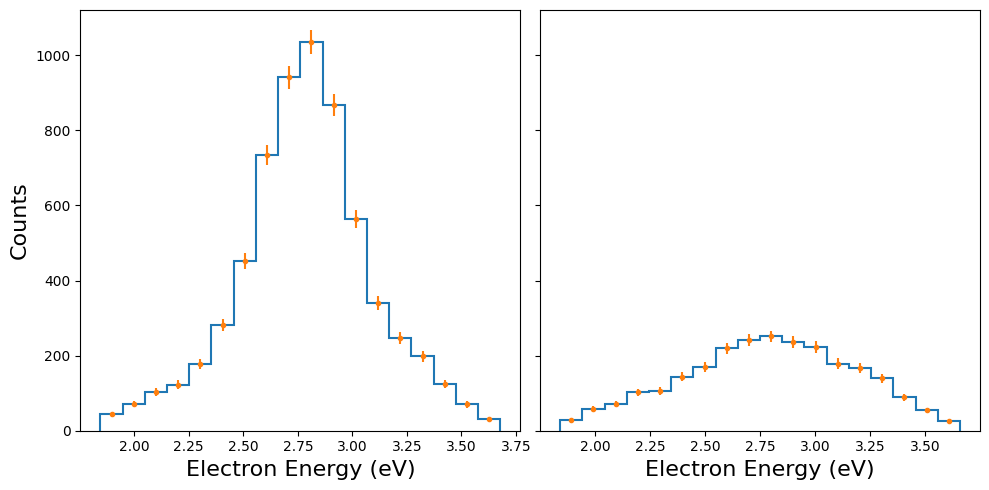

In [90]:
#########################################
### electron 1 and 2 KE distributions ###
#########################################

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)

a0,b0,_=ax1.hist(KEgate0,bins=18,histtype='step',lw=1.5)
bincenters0 = 0.5*(b0[1:]+b0[:-1])
menStd0 = np.sqrt(a0)
ax1.errorbar(bincenters0,a0,yerr=menStd0,fmt = '.')
ax1.set_xlabel('Electron Energy (eV)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax1.set_ylabel('Counts', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})

a1,b1,_=ax2.hist(KEgate1,bins=18,histtype='step',lw=1.5)
bincenters1 = 0.5*(b1[1:]+b1[:-1])
menStd1 = np.sqrt(a1)
ax2.errorbar(bincenters1,a1,yerr=menStd1,fmt = '.')
ax2.set_xlabel('Electron Energy (eV)', fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})

fig.tight_layout()
fig.show()

(mu_Ee0, sigma_Ee0) = norm.fit(KEgate0)
print(mu_Ee0)
print(sigma_Ee0)
(mu_Ee1, sigma_Ee1) = norm.fit(KEgate1)
print(mu_Ee1)
print(sigma_Ee1)

In [91]:
##################################################################
### store cleaned up electron data in array for further gating ###
##################################################################

data0 = np.array(list(zip(e_px0, e_py0, e_pz0)))
data1 = np.array(list(zip(e_px1, e_py1, e_pz1)))

# Next we gate on electron KE to select the peak for further analysis. We also slightly scale the momentum sphere to account for distortions from non-uniform field.

In [92]:
##########################
### select KE interval ###
##########################
KE_high = 3.2
KE_low = 2.4

##################
### electron 1 ###
##################
##################
### apply gate ###
##################
good_events0 = []
for event in data0:
    epx, epy, epz = event[0], event[1], event[2]
    if 27.2114*(epx**2 + epy**2 + epz**2)/2 <= KE_high and 27.2114*(epx**2 + epy**2 + epz**2)/2 >= KE_low:
        good_events0.append(event)

###############################################
############### angular sectors ###############
### electron momentum scaled in each sector ###
#### to remove momentum sphere distortions ####
###############################################
good_events_scaled0 = []
zero_to_Twopi_9_0 = []
Twopi_9_to_Threepi_9_0 = []
Threepi_9_to_Fourpi_9_0 = []
Fourpi_9_to_Fivepi_9_0 = []
Fivepi_9_to_Sixpi_9_0 = []
Sixpi_9_to_Sevenpi_9_0 = []
Sevenpi_9_to_pi_0 = []

####################################
### apply scaling in each sector ###
####################################
for event in good_events0:
    epx, epy, epz = event[0], event[1], event[2]
    epmag = np.sqrt(epx**2 + epy**2 + epz**2)
    thetaelectron = np.arccos(epz/epmag)
    
    if thetaelectron >= 0 and thetaelectron <= 2*np.pi/9:
        epx *= 1.0125 
        epy *= 1.0125 
        epz *= 1.0125 
        zero_to_Twopi_9_0.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
        
    elif thetaelectron > 2*np.pi/9 and thetaelectron <= 3*np.pi/9:
        epx *= 1.011 
        epy *= 1.011 
        epz *= 1.011 
        Twopi_9_to_Threepi_9_0.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
        
    elif thetaelectron > 3*np.pi/9 and thetaelectron <= 4*np.pi/9:
        epx *= 1.006  
        epy *= 1.006 
        epz *= 1.006 
        Threepi_9_to_Fourpi_9_0.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
        
    elif thetaelectron > 4*np.pi/9 and thetaelectron <= 5*np.pi/9:
        epx *= 1.00
        epy *= 1.00
        epz *= 1.00
        Fourpi_9_to_Fivepi_9_0.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))

    elif thetaelectron > 5*np.pi/9 and thetaelectron <= 6*np.pi/9:
        epx *= 0.996 
        epy *= 0.996 
        epz *= 0.996 
        Fivepi_9_to_Sixpi_9_0.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
    
    elif thetaelectron > 6*np.pi/9 and thetaelectron <= 7*np.pi/9:
        epx *= 0.9965 
        epy *= 0.9965 
        epz *= 0.9965 
        Sixpi_9_to_Sevenpi_9_0.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))        
    
    else:
        epx *= 0.992 
        epy *= 0.992 
        epz *= 0.992 
        Sevenpi_9_to_pi_0. append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))

    good_events_scaled0.append([epx,epy,epz])

####################################
### re-apply gate to scaled data ###
####################################
good_events00 = []
for event in good_events_scaled0:
    epx, epy, epz = event[0], event[1], event[2]
    if 27.2114*(epx**2 + epy**2 + epz**2)/2 <= KE_high and 27.2114*(epx**2 + epy**2 + epz**2)/2 >= KE_low:
        good_events00.append(event)
                
good_electrons0 = list(zip(*good_events00))

In [93]:
##################
### electron 2 ###
##################
##################
### apply gate ###
##################
good_events1 = []
for event in data1:
    epx, epy, epz = event[0], event[1], event[2]
    if 27.2114*(epx**2 + epy**2 + epz**2)/2 <= KE_high and 27.2114*(epx**2 + epy**2 + epz**2)/2 >= KE_low:
        good_events1.append(event)

###############################################
############### angular sectors ###############
### electron momentum scaled in each sector ###
#### to remove momentum sphere distortions ####
###############################################
good_events_scaled1 = []
zero_to_Twopi_9_1 = []
Twopi_9_to_Threepi_9_1 = []
Threepi_9_to_Fourpi_9_1 = []
Fourpi_9_to_Fivepi_9_1 = []
Fivepi_9_to_Sixpi_9_1 = []
Sixpi_9_to_Sevenpi_9_1 = []
Sevenpi_9_to_pi_1 = []

####################################
### apply scaling in each sector ###
####################################
for event in good_events1:
    epx, epy, epz = event[0], event[1], event[2]
    epmag = np.sqrt(epx**2 + epy**2 + epz**2)
    thetaelectron = np.arccos(epz/epmag)
    
    if thetaelectron >= 0 and thetaelectron <= 2*np.pi/9:
        epx *= 1.0125 
        epy *= 1.0125 
        epz *= 1.0125 
        zero_to_Twopi_9_1.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
        
    elif thetaelectron > 2*np.pi/9 and thetaelectron <= 3*np.pi/9:
        epx *= 1.011 
        epy *= 1.011 
        epz *= 1.011 
        Twopi_9_to_Threepi_9_1.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
        
    elif thetaelectron > 3*np.pi/9 and thetaelectron <= 4*np.pi/9:
        epx *= 1.006 
        epy *= 1.006 
        epz *= 1.006 
        Threepi_9_to_Fourpi_9_1.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
        
    elif thetaelectron > 4*np.pi/9 and thetaelectron <= 5*np.pi/9:
        epx *= 1.00
        epy *= 1.00
        epz *= 1.00
        Fourpi_9_to_Fivepi_9_1.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))

    elif thetaelectron > 5*np.pi/9 and thetaelectron <= 6*np.pi/9:
        epx *= 0.996 
        epy *= 0.996 
        epz *= 0.996 
        Fivepi_9_to_Sixpi_9_1.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))
    
    elif thetaelectron > 6*np.pi/9 and thetaelectron <= 7*np.pi/9:
        epx *= 0.9965  
        epy *= 0.9965  
        epz *= 0.9965  
        Sixpi_9_to_Sevenpi_9_1.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))        
    
    else:
        epx *= 0.992
        epy *= 0.992
        epz *= 0.992
        Sevenpi_9_to_pi_1.append(float(27.2114*(epx**2 + epy**2 + epz**2)/2))

    good_events_scaled1.append([epx,epy,epz])

####################################
### re-apply gate to scaled data ###
####################################
good_events11 = []
for event in good_events_scaled1:
    epx, epy, epz = event[0], event[1], event[2]
    if 27.2114*(epx**2 + epy**2 + epz**2)/2 <= KE_high and 27.2114*(epx**2 + epy**2 + epz**2)/2 >= KE_low:
        good_events11.append(event)
                
good_electrons1 = list(zip(*good_events11))

In [94]:
##########################################################
############# verify scaling in each sector ##############
### mean electron KE in each sector should be the same ###
##########################################################
print(np.mean(zero_to_Twopi_9_0))
print(np.mean(Twopi_9_to_Threepi_9_0))
print(np.mean(Threepi_9_to_Fourpi_9_0))
print(np.mean(Fourpi_9_to_Fivepi_9_0))
print(np.mean(Fivepi_9_to_Sixpi_9_0))
print(np.mean(Sixpi_9_to_Sevenpi_9_0))
print(np.mean(Sevenpi_9_to_pi_0))

2.8026807100830244
2.8019583935149432
2.802643577629099
2.800339510335287
2.7984647367704305
2.80846435254928
2.8072667454816425


In [95]:
########################################
### merge data from electron 1 and 2 ###
########################################
e_px = np.concatenate((np.array(good_electrons0[0]),np.array(good_electrons1[0])))
e_py = np.concatenate((np.array(good_electrons0[1]),np.array(good_electrons1[1])))
e_pz = np.concatenate((np.array(good_electrons0[2]),np.array(good_electrons1[2])))

In [96]:
######################################
### number of events after merging ###
######################################
print(len(e_px))

6749


/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1391802970.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


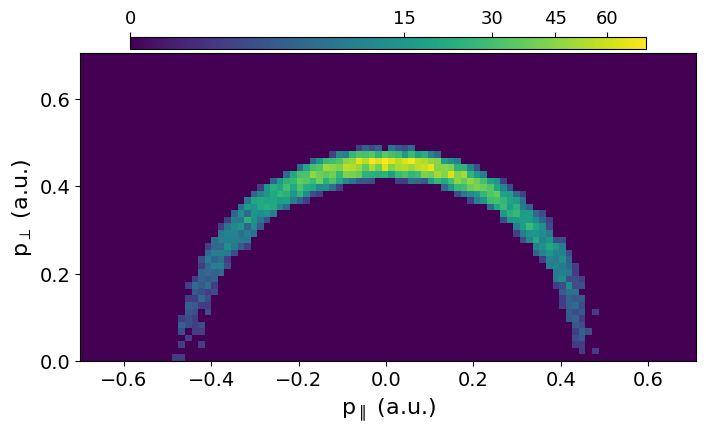

In [97]:
###############################################
### electron p_longitudinal vs p_transverse ###
###############################################
p_e_longitudinal = e_pz
p_e_transverse = np.sqrt(e_px**2 + e_py**2)

p_ez_edges = np.arange(0,0.715,0.015)
p_ex_edges = np.arange(-0.7,0.715,0.015)
H_e_px_pz, p_ex_edges, p_ez_edges = np.histogram2d(p_e_longitudinal,p_e_transverse,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz = H_e_px_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(8,4))

im = ax_a.imshow(H_e_px_pz, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',aspect=1/1,norm = PowerNorm(gamma =1 / 2.5))
ax_a.set_ylabel('p$_{\perp}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_xlabel('p$_{\parallel}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=14)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 13)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2653463549.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


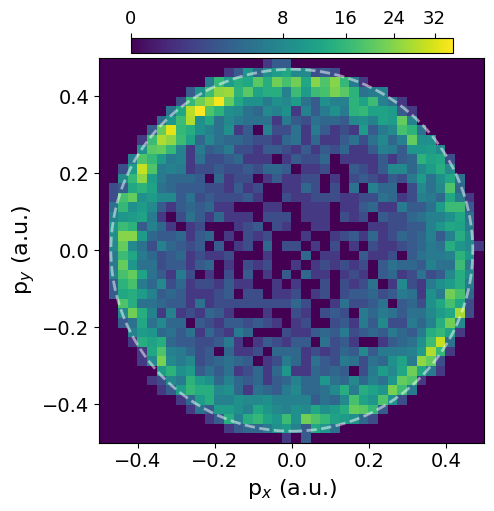

In [98]:
#########################
### electron px vs py ###
#########################
p_ex_edges = np.arange(-0.5,0.525,0.025)
p_ey_edges = np.arange(-0.5,0.525,0.025)
H_e_px_py, p_ex_edges, p_ey_edges = np.histogram2d(e_px,e_py,bins=(p_ex_edges,p_ey_edges))
H_e_px_py = H_e_px_py.T

fig_a, ax_a = plt.subplots(1,1,figsize=(5,5))

im = ax_a.imshow(H_e_px_py, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ey_edges[0], p_ey_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 1 / 2))
ax_a.set_xlabel('p$_{x}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('p$_{y}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=14)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 13)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

ellipse1 = Ellipse(xy=(0.0, 0.0),width=0.94,height=0.94,angle=0,edgecolor='w',fc='None',lw=2.0,ls='--',alpha=0.5)
ax_a.add_patch(ellipse1)

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1624266581.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


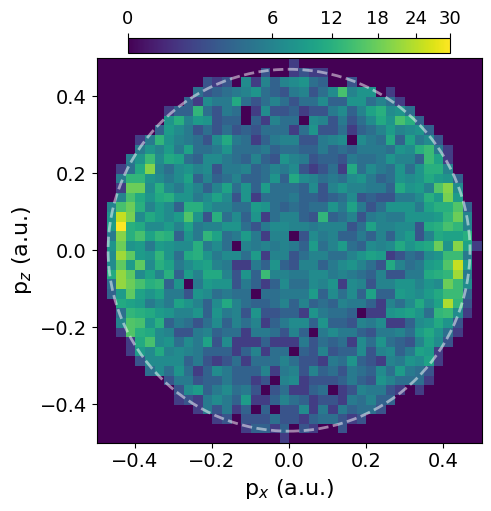

In [99]:
#########################
### electron px vs pz ###
#########################
p_ex_edges = np.arange(-0.5,0.525,0.025)
p_ez_edges = np.arange(-0.5,0.525,0.025)
H_e_px_pz, p_ex_edges, p_ez_edges = np.histogram2d(e_px,e_pz,bins=(p_ex_edges,p_ez_edges))
H_e_px_pz = H_e_px_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(5,5))

im = ax_a.imshow(H_e_px_pz, origin='lower', extent=[p_ex_edges[0], p_ex_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 1 / 2))
ax_a.set_xlabel('p$_{x}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('p$_{z}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=14)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 13)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

ellipse1 = Ellipse(xy=(0.0, 0.0),width=0.94,height=0.94,angle=0,edgecolor='w',fc='None',lw=2.0,ls='--',alpha=0.5)
ax_a.add_patch(ellipse1)

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/4275359722.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


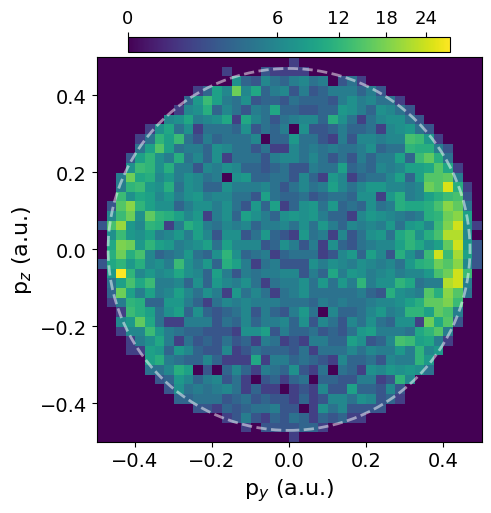

In [100]:
#########################
### electron py vs pz ###
#########################
p_ey_edges = np.arange(-0.5,0.525,0.025)
p_ez_edges = np.arange(-0.5,0.525,0.025)
H_e_py_pz, p_ey_edges, p_ez_edges = np.histogram2d(e_py,e_pz,bins=(p_ey_edges,p_ez_edges))
H_e_py_pz = H_e_py_pz.T

fig_a, ax_a = plt.subplots(1,1,figsize=(5,5))

im = ax_a.imshow(H_e_py_pz, origin='lower', extent=[p_ey_edges[0], p_ey_edges[-1], p_ez_edges[0], p_ez_edges[-1]],cmap = 'viridis',norm = PowerNorm(gamma = 1 / 2))
ax_a.set_xlabel('p$_{y}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('p$_{z}$ (a.u.)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=14)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 13)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

ellipse1 = Ellipse(xy=(0.0, 0.0),width=0.94,height=0.94,angle=0,edgecolor='w',fc='None',lw=2.0,ls='--',alpha=0.5)
ax_a.add_patch(ellipse1)

#fig_a.tight_layout()
fig_a.show()

In [101]:
###########################
### compute electron KE ###
###########################
e_energy = 27.2114*(e_px**2 + e_py**2 + e_pz**2)/2

2.802859921017775
0.1863679953411672


/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/4164668825.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


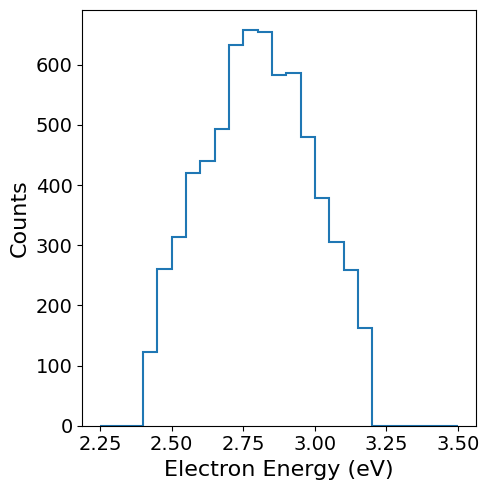

In [102]:
################################
### electron KE distribution ###
################################
(mu_Ee, sigma_Ee) = norm.fit(e_energy)
print(mu_Ee)
print(sigma_Ee)

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.hist(e_energy,bins=np.linspace(2.25,3.5,26),histtype='step',lw=1.5)
ax.set_xlabel('Electron Energy (eV)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=14)

fig.tight_layout()
fig.show()

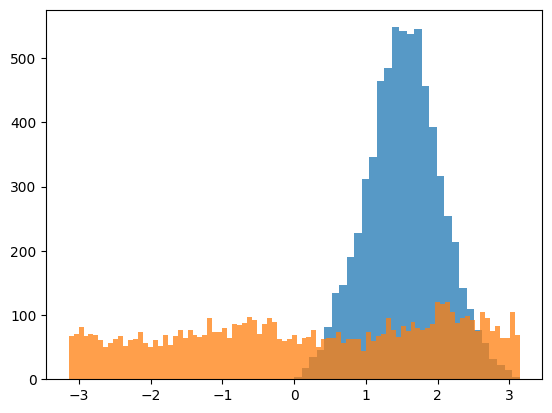

In [103]:
###################################################
### compute electon theta and phi distributions ###
###################################################
e_p_mag = np.sqrt(e_px**2 + e_py**2 + e_pz**2)
theta_electron = np.arccos(e_pz/e_p_mag)
cos_theta_electron = e_pz/e_p_mag
phi_electron = np.arctan2(e_py,e_px)

for phi in phi_electron:
    if phi < 0.0:
        phi += 2*np.pi        
phi_electron = phi_electron

theta_radius, theta_radian, _ = plt.hist(theta_electron,bins=np.linspace(0,np.pi,num=31),alpha=0.75)
phi_radius, phi_radian, _ = plt.hist(phi_electron,bins=np.linspace(-np.pi,np.pi,num=92),alpha=0.75)

(array([ 51.,  78.,  91., 113., 127., 176., 188., 198., 240., 268., 301.,
        288., 342., 368., 343., 345., 360., 344., 353., 283., 325., 258.,
        239., 230., 178., 175., 155., 151., 108.,  73.]),
 array([-9.99874058e-01, -9.33232242e-01, -8.66590425e-01, -7.99948609e-01,
        -7.33306793e-01, -6.66664976e-01, -6.00023160e-01, -5.33381343e-01,
        -4.66739527e-01, -4.00097711e-01, -3.33455894e-01, -2.66814078e-01,
        -2.00172261e-01, -1.33530445e-01, -6.68886286e-02, -2.46812206e-04,
         6.63950042e-02,  1.33036821e-01,  1.99678637e-01,  2.66320453e-01,
         3.32962270e-01,  3.99604086e-01,  4.66245903e-01,  5.32887719e-01,
         5.99529535e-01,  6.66171352e-01,  7.32813168e-01,  7.99454985e-01,
         8.66096801e-01,  9.32738617e-01,  9.99380434e-01]),
 <BarContainer object of 30 artists>)

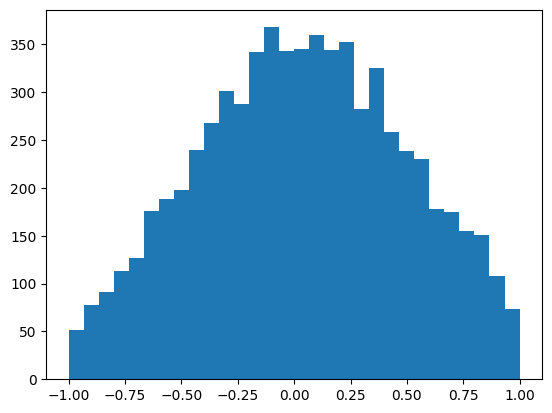

In [104]:
###########################
### cos(theta_electron) ###
###########################
plt.hist(cos_theta_electron,bins=30)

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1120242292.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


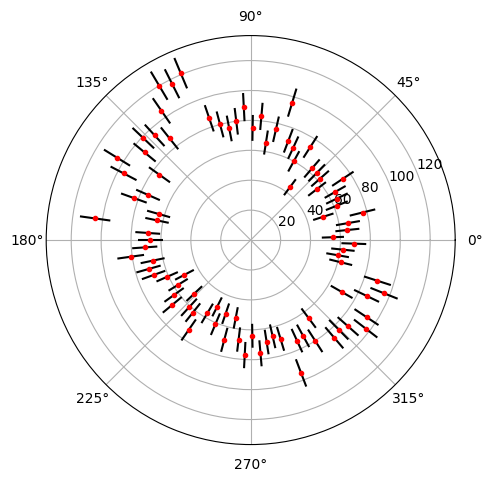

In [105]:
####################
### phi_electron ###
####################
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize = (5,5))

radius_error = [np.sqrt(x) for x in phi_radius]
ax.errorbar(phi_radian[:-1], phi_radius, yerr = radius_error, fmt = 'r.', ecolor = 'k')
ax.grid(True)
fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/674518720.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


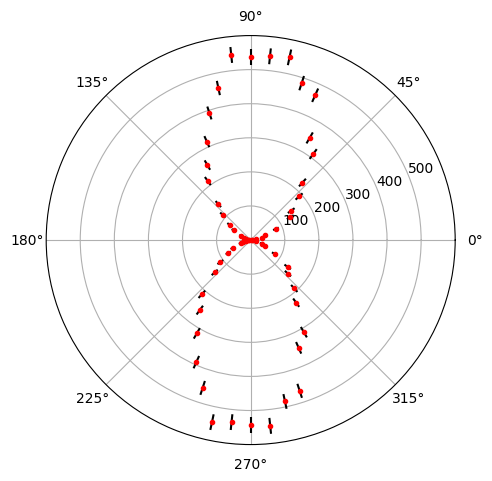

In [106]:
######################
### theta_electron ###
######################
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize = (5,5))

radius_error = np.array([np.sqrt(x) for x in theta_radius])
radius_error_ = np.flip(radius_error)

theta = np.concatenate((theta_radian[:-1],theta_radian[:-1]+np.pi))
radius = np.concatenate((theta_radius,np.flip(theta_radius)))
error = np.concatenate((radius_error,radius_error_))

ax.errorbar(theta, radius, yerr = error, fmt = 'r.', ecolor = 'k')
ax.grid(True)

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2847759010.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


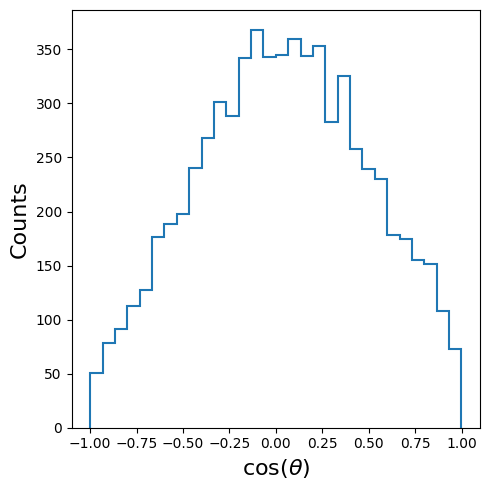

In [107]:
###########################
### cos(theta_electron) ###
###########################
fig, ax = plt.subplots(1, 1, figsize = (5,5))

radius_, cos_theta_, _  = ax.hist(cos_theta_electron, bins=30,histtype='step',lw=1.5)
ax.set_xlabel('cos($\\theta$)', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2327354094.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


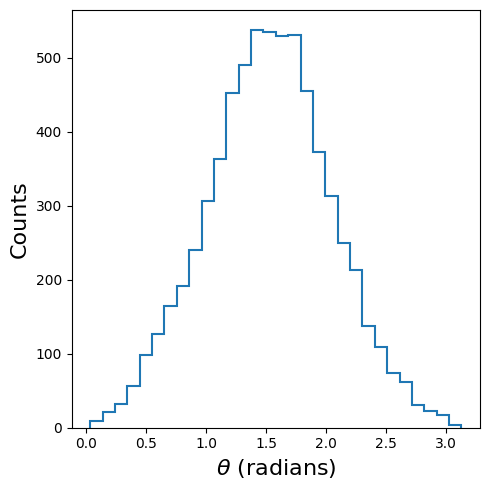

In [108]:
######################
### theta_electron ###
######################
fig, ax = plt.subplots(1, 1, figsize = (5,5))

radius, cos_theta, _  = ax.hist(theta_electron,bins=30,histtype='step',lw=1.5)
ax.set_xlabel('$\\theta$ (radians)', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)

fig.tight_layout()
fig.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/1091586445.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


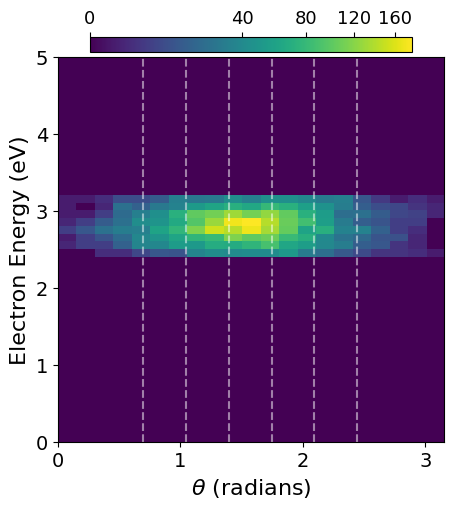

In [109]:
############################
### theta_electron vs KE ###
############################
Ee_edges = np.arange(0.0,5.1,0.1)
theta_edges = np.arange(0.0,np.pi+0.15,0.15)
H_Ee_theta, theta_edges, Ee_edges = np.histogram2d(theta_electron,e_energy,bins=(theta_edges,Ee_edges))
H_Ee_theta = H_Ee_theta.T

fig_a, ax_a = plt.subplots(1,1,figsize=(5,5))

im = ax_a.imshow(H_Ee_theta, origin='lower', extent=[theta_edges[0], theta_edges[-1], Ee_edges[0], Ee_edges[-1]],aspect=np.pi/5,cmap = 'viridis',norm = PowerNorm(gamma = 1 / 2))
ax_a.set_xlabel('$\\theta$ (radians)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('Electron Energy (eV)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=14)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 13)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

ax_a.axvline(2*np.pi/9,c='w',ls='--',alpha=0.5)
ax_a.axvline(3*np.pi/9,c='w',ls='--',alpha=0.5)
ax_a.axvline(4*np.pi/9,c='w',ls='--',alpha=0.5)
ax_a.axvline(5*np.pi/9,c='w',ls='--',alpha=0.5)
ax_a.axvline(6*np.pi/9,c='w',ls='--',alpha=0.5)
ax_a.axvline(7*np.pi/9,c='w',ls='--',alpha=0.5)

#fig_a.tight_layout()
fig_a.show()

In [110]:
#####################################################
### dividing by Jacobian to properly scale counts ###
#####################################################
theta_centers = 0.5*(theta_edges[1:]+theta_edges[:-1])
scaled = np.zeros(np.shape(H_Ee_theta))
for n in range(50):
    scaled[n,:] = H_Ee_theta[n,:]/np.sin(theta_centers)

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3473523747.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


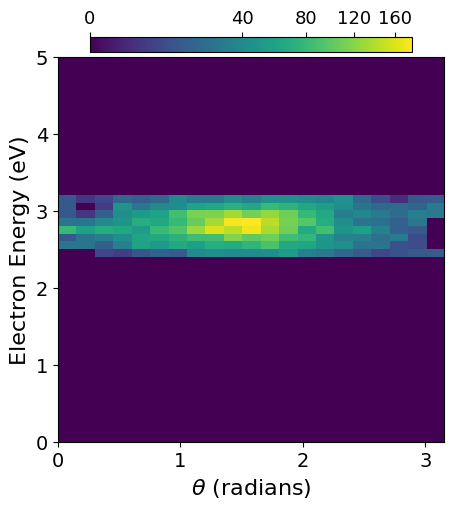

In [111]:
############################################
### properly scaled theta_electron vs KE ###
############################################
fig_a, ax_a = plt.subplots(1,1,figsize=(5,5))

im = ax_a.imshow(scaled, origin='lower', extent=[theta_edges[0], theta_edges[-1], Ee_edges[0], Ee_edges[-1]],aspect=np.pi/5,cmap = 'viridis',norm = PowerNorm(gamma = 1 / 2))
ax_a.set_xlabel('$\\theta$ (radians)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('Electron Energy (eV)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=14)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 13)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

#fig_a.tight_layout()
fig_a.show()

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3776924979.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_a.show()


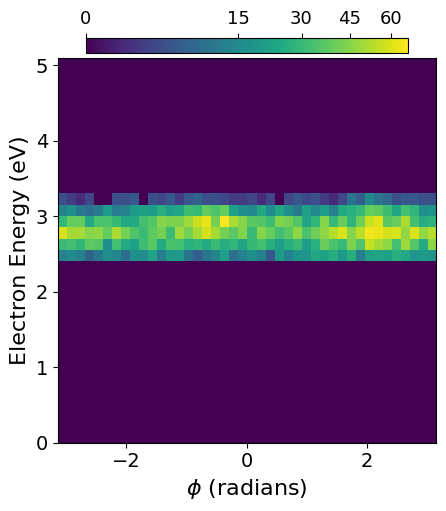

In [112]:
##########################
### phi_electron vs KE ###
##########################
Ee_edges = np.arange(0.0,5.15,0.15)
phi_edges = np.arange(-np.pi,np.pi+0.15,0.15)
H_Ee_phi, phi_edges, Ee_edges = np.histogram2d(phi_electron,e_energy,bins=(phi_edges,Ee_edges))
H_Ee_phi = H_Ee_phi.T

fig_a, ax_a = plt.subplots(1,1,figsize=(5,5))

im = ax_a.imshow(H_Ee_phi, origin='lower', extent=[phi_edges[0], phi_edges[-1], Ee_edges[0], Ee_edges[-1]],aspect=2*np.pi/5,cmap = 'viridis',norm = PowerNorm(gamma = 1 / 2))
ax_a.set_xlabel('$\phi$ (radians)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.set_ylabel('Electron Energy (eV)',fontsize=16,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax_a.tick_params(labelsize=14)

cb_ax = fig_a.add_axes([0.19, 0.89, 0.645, 0.03])
cb = fig_a.colorbar(im, cax = cb_ax, orientation = 'horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

cb.ax.tick_params(labelsize = 13)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

#fig_a.tight_layout()
fig_a.show()

In [113]:
bincenters = 0.5*(cos_theta[1:]+cos_theta[:-1])

###################################################################
### expression for 2-photon photoelectron angular distributions ###
################### using Legendre polynomials ####################
###################################################################
def Legendre(x,a,b,c):
    return (a*1 + b*(0.5*(3*np.cos(x)**2 - 1)) +  
            c*(1/8 * (35*np.cos(x)**4 - 30*np.cos(x)**2 + 3)))

################################################################
### dividing by Jacobian to properly scale counts and errors ###
################################################################
radius_scaled = [radius[n]/np.sin(bincenters[n]) for n in range(len(bincenters))]
radius_scaled_error = [np.sqrt(n) for n in radius_scaled]
radius_scaled_error_ = [np.sqrt(radius[n])/np.sin(bincenters[n]) for n in range(len(bincenters))]

In [114]:
##############################################
### fit theta_electron with above function ###
##############################################
popt_, pcov_ = curve_fit(Legendre, bincenters, radius_scaled, sigma = radius_scaled_error_)
L_opt_ = Legendre(theta, popt_[0], popt_[1], popt_[2])

##############################
### fitted beta parameters ###
##############################
betas = popt_/popt_[0]
print((betas[1],betas[2]))

########################################
### errors on fitted beta parameters ###
########################################
vars_ = np.sqrt(pcov_)/popt_[0]
print((vars_[1,1],vars_[2,2]))

(-0.9437629834199235, 0.22057911122820775)Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

(0.03777445047992904, 0.04556531783710129)


/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3888341026.py:16: RuntimeWarning: invalid value encountered in sqrt
  vars_ = np.sqrt(pcov_)/popt_[0]


/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/3384643612.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


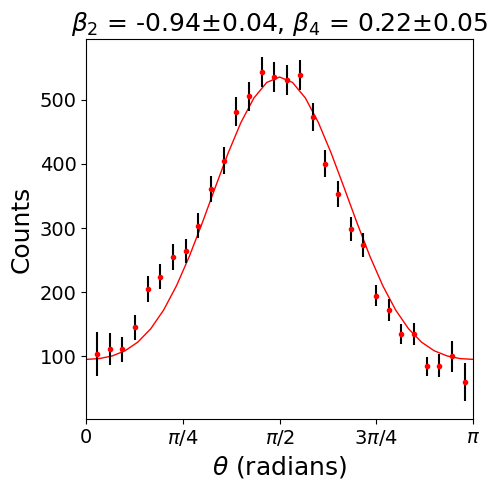

In [115]:
########################################
### photoelectron theta distribution ###
####### with error bars and fit ########
## these error bars come from the fit ##
########################################
fig, ax = plt.subplots(1,1,figsize = (5,5))

ax.plot(theta, L_opt_, '-r', linewidth = 1.0, label = 'Fit')
ax.errorbar(bincenters, radius_scaled, yerr = radius_scaled_error_, fmt = 'r.', ecolor = 'k')
ax.set_xlim(0,np.pi)
ax.set_xlabel('$\\theta$ (radians)', fontsize=18,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts', fontsize=18,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_title('$\\beta_{2}$ = '+str(np.round(betas[1],2))+'$\pm$'+str(np.round(vars_[1,1],2))+
             ', $\\beta_{4}$ = '+str(np.round(betas[2],2))+'$\pm$'+str(np.round(vars_[2,2],2)), 
             fontsize=18,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})

plt.xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi], ('0', '$\pi$/4', '$\pi$/2', '3$\pi$/4', '$\pi$'),fontsize=14)
plt.yticks(fontsize=14)

fig.tight_layout()
fig.show()

In [117]:
###################################################
######### define terms in expression for ##########
### 2-photon photoelectron angular distribution ###
###################################################
def P0(x):
    return 1
def P2(x):
    return 0.5*(3*np.cos(x)**2 - 1)
def P4(x):
    return 1/8 * (35*np.cos(x)**4 - 30*np.cos(x)**2 + 3)

#############################################
### betas calculated using MC integration ###
#############################################
beta0 = 0
beta2 = 0
beta4 = 0
for x in theta_electron:
    beta0 += P0(x)
    beta2 += P2(x)
    beta4 += P4(x)   

beta0 = (2/len(theta_electron)) * 1 * beta0 #(5 = 2*0 + 1)
beta2 = (2/len(theta_electron)) * 5 * beta2 #(5 = 2*2 + 1)
beta4 = (2/len(theta_electron)) * 9 * beta4 #(9 = 2*4 + 1)

beta2_norm = beta2/beta0
beta4_norm = beta4/beta0

print(beta2_norm)
print(beta4_norm)

-0.927860619808202
0.2417202175280086


In [118]:
#######################################
##### betas and errors calculated #####
### using statistical bootstrapping ###
#######################################
twos = dict()
fours = dict()
be0 = len(theta_electron)
for i in range(1000*100):

    choice = np.random.choice(theta_electron, len(theta_electron), replace=True)

    be2 = np.polynomial.legendre.legval(np.cos(choice), [0,0,1,0,0]).sum() * 5
    be4 = np.polynomial.legendre.legval(np.cos(choice), [0,0,0,0,1]).sum() * 9
    
    twos[i] = be2 / be0
    fours[i] = be4 / be0
    
twos = pd.Series(twos)
fours = pd.Series(fours)

<Axes: >

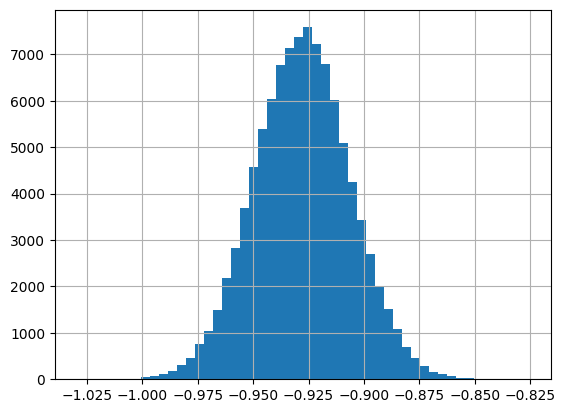

In [119]:
#############################################
### beta2 distribution from bootstrapping ###
#############################################
twos.hist(bins=50)

<Axes: >

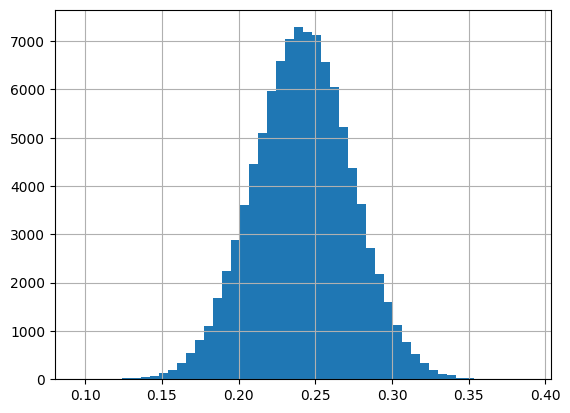

In [120]:
#############################################
### beta4 distribution from bootstrapping ###
#############################################
fours.hist(bins=50)

In [121]:
###########################################
### beta2 statistics from bootstrapping ###
###########################################
twos.describe()

count    100000.000000
mean         -0.927907
std           0.021614
min          -1.029363
25%          -0.942538
50%          -0.927868
75%          -0.913415
max          -0.825825
dtype: float64

In [122]:
###########################################
### beta4 statistics from bootstrapping ###
###########################################
fours.describe()

count    100000.000000
mean          0.241706
std           0.032011
min           0.094841
25%           0.220227
50%           0.241782
75%           0.263302
max           0.388906
dtype: float64

In [123]:
###################
### fit to data ###
###################
L_opt_cons = Legendre(theta, popt_[0], beta2_norm*popt_[0], beta4_norm*popt_[0])

/var/folders/1z/v3kjn3z54nb7b8cx5hqg_y1h0000gp/T/ipykernel_70088/2053979723.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


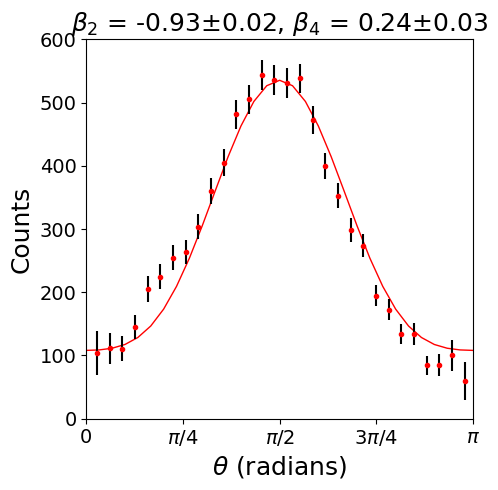

In [127]:
########################################
### photoelectron theta distribution ###
####### with error bars and fit ########
########################################
fig, ax = plt.subplots(1,1,figsize = (5,5))

ax.plot(theta, L_opt_cons, '-r', linewidth = 1.0, label = 'Fit')
ax.errorbar(bincenters, radius_scaled, yerr = radius_scaled_error_, fmt = 'r.', ecolor = 'k')
ax.set_xlim(0,np.pi)
ax.set_xlabel('$\\theta$ (radians)', fontsize=18,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts', fontsize=18,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_title('$\\beta_{2}$ = '+str(np.round(beta2_norm,2))+'$\pm$'+str(np.round(twos.std(),2))+
             ', $\\beta_{4}$ = '+str(np.round(beta4_norm,2))+'$\pm$'+str(np.round(fours.std(),2)), fontsize=18,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})

plt.xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi], ('0', '$\pi$/4', '$\pi$/2', '3$\pi$/4', '$\pi$'),fontsize=14)
plt.yticks(fontsize=14)

ax.set_ylim(0,600)

fig.tight_layout()
fig.show()